# TODO

K-folds sequential:
(Train on first set, then test on second)
[1] [2]
[1 2] [3]
...

Multiple initializations of weights


Grid search all the hyperparameters

Try other optimizers (faster?)

Try sampling by geographic location, continent, GDP, etc.

Note: ['Eritrea',
 'Fragile and conflict affected situations',
 'Croatia',
 'Israel',
 'Kuwait',
 'Luxembourg',
 'New Zealand'] all are missing some years.

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [63]:
import numpy as np
import csv
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow.contrib.rnn as rnn
import time
from sklearn.preprocessing import StandardScaler
from matplotlib.animation import FuncAnimation
import os
from IPython.display import HTML
import decimal
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from random import random
import matplotlib.patheffects as PathEffects
from matplotlib import gridspec
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping
from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model
from keras.models import load_model 
import keras.backend as K
import h5py as h5py

### Reads data into separate arrays for each county

In [64]:
def col(vec):
    return np.reshape(vec, (np.size(vec),1))
def row(vec):
    return np.reshape(vec, (1,np.size(vec)))
def frange(x, y, jump):
    while x < y - .00001:
        yield float(x)
        x += jump
def to_float(x):
    if x == "NA" or x.strip() == "":
        return np.nan
    else:
        return np.float32(x)

In [65]:
county_data = []
counties = ["Alameda", "Alpine", "Amador", "Butte", "Calaveras", "Colusa", "Contra Costa", "Del Norte", "El Dorado", "Fresno", "Glenn", "Humboldt", "Imperial",
            "Inyo", "Kern", "Kings", "Lake", "Lassen", "Los Angeles", "Madera", "Marin", "Mariposa", "Mendocino", "Merced", "Modoc", "Mono", "Monterey", "Napa",
            "Nevada", "Orange", "Placer", "Plumas", "Riverside", "Sacramento", "San Benito", "San Bernardino", "San Diego", "San Francisco", "San Joaquin",
            "San Luis Obispo", "San Mateo", "Santa Barbara", "Santa Clara", "Santa Cruz", "Shasta", "Sierra", "Siskiyou", "Solano", "Sonoma", "Stanislaus",
            "Sutter", "Tehama", "Trinity", "Tulare", "Tuolumne", "Ventura", "Yolo", "Yuba"]
with open("Monthly_CSV/CountyMonthlyData.csv", 'r+', encoding='utf_8') as f:
    reader = csv.reader(f)
    header = True
    first = True
    for datarow in reader:
        if header:
            header = False
        else:
            if first:
                first = False
                for i in range(58):
                    county_data.append([to_float(item) for item in datarow[(i*11+2):(i*11+12)]])
            else:
                for i in range(58):
                    county_data[i] = np.vstack((county_data[i],[to_float(item) for item in datarow[(i*11+2):(i*11+12)]]))
with open("MedianHouseholdCost.csv", 'r+', encoding = 'utf_8') as f:
    reader = csv.reader(f)
    householdCosts = []
    header = True
    for datarow in reader:
        if header:
            header = False
        else:
            householdCosts.append(to_float(datarow[1].replace(",","")))
with open("Monthly_CSV/HistoricalHAIForReading.csv", 'r+', encoding='utf_8') as f:
    reader = csv.reader(f)
    header = True
    first = True
    for datarow in reader:
        if first:
            first = False
            hai = [to_float(item.replace('\ufeff', '')) for item in datarow]
        else:
            hai = np.vstack((hai, [to_float(item) for item in datarow]))
hai = hai[0:180,:]
with open("alamedahai.csv", 'r+', encoding = 'utf_8') as f:
    reader = csv.reader(f)
    alamedaHAI = []
    header = True
    for datarow in reader:
        alamedaHAI.append(to_float(datarow[0].replace("%","").replace('\ufeff', ''))/100)
        
newAlamedaHAI = []
for i in range(180):
    newAlamedaHAI.append(alamedaHAI[i])
for i in range(48):
    prev = newAlamedaHAI[-1]
    cur = alamedaHAI[180+i]
    for j in range(3):
        newAlamedaHAI.append(prev + (cur - prev) * (j+1) / 3)
alamedaHAI = newAlamedaHAI

## Keras feedforward neural net

In [688]:
names = ["Median Home Price", "Vacancy Rates", "Building permits", 
"Unemployment", "ValuePerSquareFoot", "Foreclosures", "Gas Consumption", 
"Electricity", "Median Income", "Population Density"]
hai = alamedaHAI[121:290]
data_points = np.array(county_data[0][132:301,:])
inds = [3,6,7,8,9]
features = data_points[:,inds]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)
haiscaler = StandardScaler()
scaled_hai = scaler.fit_transform(col(hai))
x_train, x_test, y_train, y_test = train_test_split(scaled_data, scaled_hai, test_size=0.2, random_state=0)
model = Sequential()
model.add(Dense(units=5, activation='relu', input_dim=5))
model.add(Dense(units=1, activation='linear'))
model.compile(loss='mean_squared_error',
              optimizer='sgd')
num_epochs = 400
for i in range(20):
    model.fit(x_train, y_train, epochs=num_epochs, batch_size=32, verbose=0)
    loss = model.evaluate(x_test, y_test)
    print((i + 1) * num_epochs, "epochs:",loss)

34/34 [==============================] - 0s 4ms/step
400 epochs: 0.168582419262
34/34 [==============================] - 0s 98us/step
800 epochs: 0.13373814085
34/34 [==============================] - 0s 92us/step
1200 epochs: 0.132296979427
34/34 [==============================] - 0s 93us/step
1600 epochs: 0.129441252526
34/34 [==============================] - 0s 161us/step
2000 epochs: 0.126575256095
34/34 [==============================] - 0s 86us/step
2400 epochs: 0.128037094193
34/34 [==============================] - 0s 87us/step
2800 epochs: 0.127224932699
34/34 [==============================] - 0s 116us/step
3200 epochs: 0.12590663661
34/34 [==============================] - 0s 113us/step
3600 epochs: 0.12563035418
34/34 [==============================] - 0s 133us/step
4000 epochs: 0.121320880511
34/34 [==============================] - 0s 86us/step
4400 epochs: 0.125085329308
34/34 [==============================] - 0s 84us/step
4800 epochs: 0.117955511107
34/34 [===========

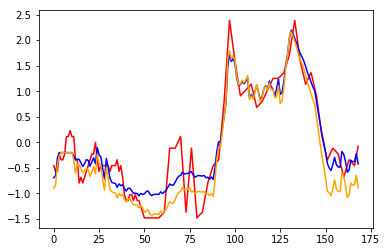

In [673]:
plt.plot(scaled_hai,color='red')
plt.plot(model.predict(scaled_data),color='blue')
plt.plot(model.predict(1.2*scaled_data), color='orange')
plt.show()

In [6]:
def scale_feature(data, i, scale):
    copy = scaled_data.copy()
    copy[:,i] = scale * copy[:,i]
    return copy

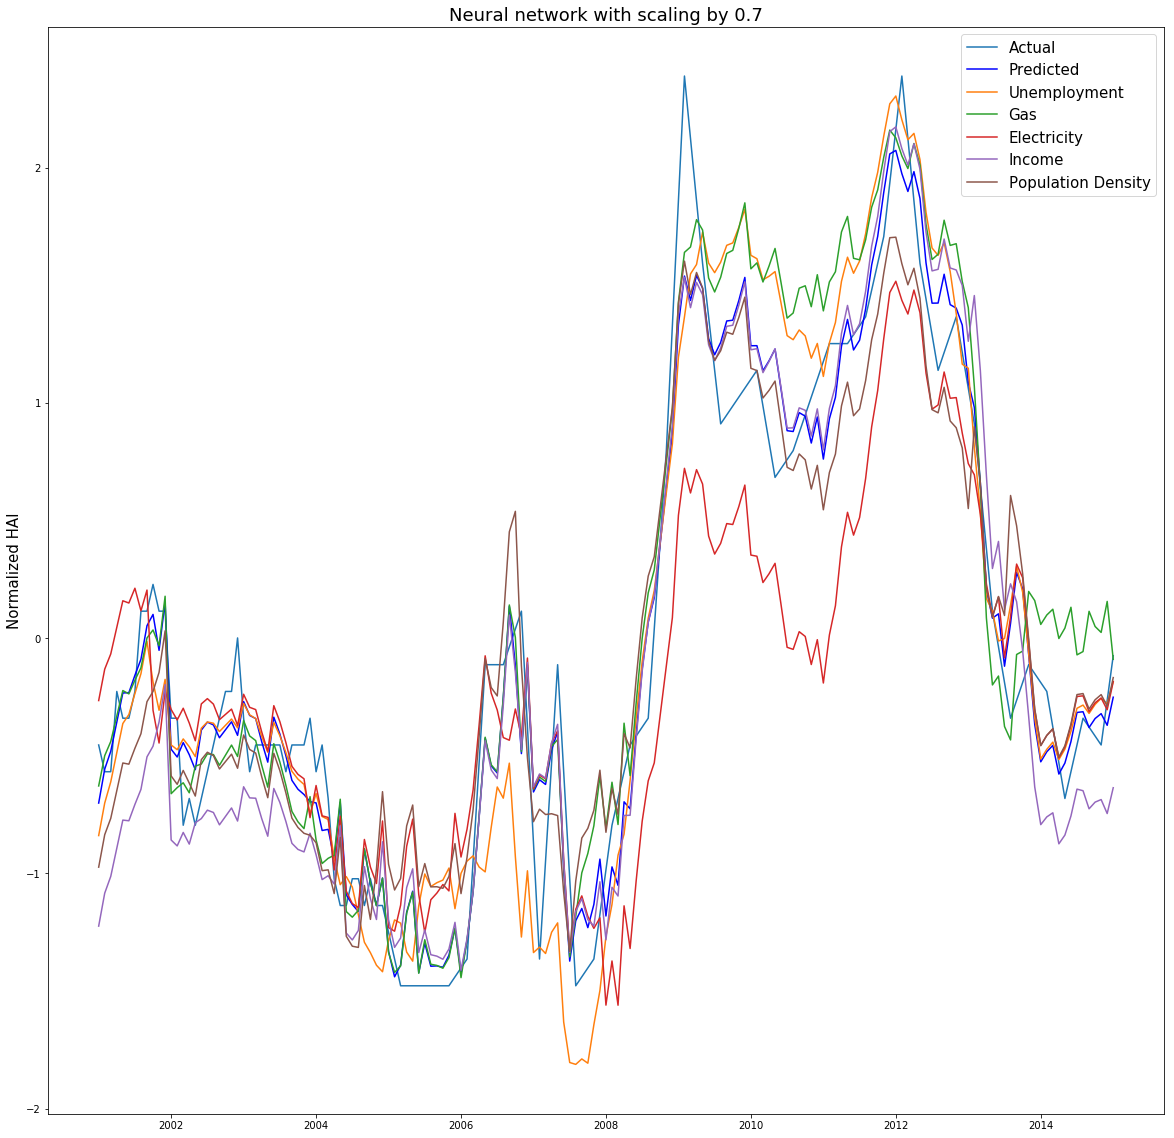

In [689]:
plt.figure(figsize = (20,20))
daterange = list(frange(2001,len(scaled_hai)/12 + 2001,1/12))
scale = .7
plt.plot(daterange,scaled_hai)
plt.plot(daterange,model.predict(scaled_data),color='blue')
for i in range(scaled_data.shape[1]):
    plt.plot(daterange,model.predict(scale_feature(scaled_data, i, scale)))
plt.legend(["Actual", "Predicted", "Unemployment", "Gas", "Electricity", "Income", "Population Density"],prop={'size': 15})
plt.title("Neural network with scaling by " + str(scale), size=18)
plt.ylabel("Normalized HAI", size=15)
plt.savefig("NNComparison" + str(scale) + ".png")
plt.show()

## Autoencoder

In [56]:
names = ["Median Home Price", "Vacancy Rates", "Building permits", 
"Unemployment", "ValuePerSquareFoot", "Foreclosures", "Gas Consumption", 
"Electricity", "Median Income", "Population Density"]
hai = alamedaHAI[121:290]
data_points = np.array(county_data[0][132:301,:])
inds = [3,6,7,8,9]
predinds = [0,1,2,4,5,8]
features = data_points[:,inds]
preds = data_points[:,predinds]
predScaler = StandardScaler()
scaled_preds = predScaler.fit_transform(preds)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)
x_train, x_test, y_train, y_test = train_test_split(scaled_data, scaled_preds, test_size=0.2, random_state=0)
edmodel = Sequential()
edmodel.add(Dense(units=5, activation='relu', input_dim=5))
edmodel.add(Dense(units=1, activation='relu', name = "encoding"))
intermediate_layer_model = Model(inputs=edmodel.input,
                                 outputs=edmodel.get_layer("encoding").output)
edmodel.add(Dense(units=5, activation='relu'))
edmodel.add(Dense(units=6, activation='linear'))
edmodel.compile(loss='mean_squared_error',
              optimizer='sgd')
num_epochs = 400
for i in range(20):
    edmodel.fit(x_train, y_train, epochs=num_epochs, batch_size=32, verbose=0)
    trainloss = edmodel.evaluate(x_train, y_train)
    testloss = edmodel.evaluate(x_test, y_test)
    print((i + 1) * num_epochs, "epochs: (train, test, ind) = (" + str(trainloss) + ", " 
          + str(testloss) + ", " + str(intermediate_layer_model.predict(row(scaled_data[-1, :]))[0,0]) + ")")
timename = time.strftime("%m%d-%H%M%S", time.gmtime())
edmodel.save("Models/encoder" + time.strftime("%m%d-%H%M%S", time.gmtime())+".h5")
#intermediate_output = intermediate_layer_model.predict(data)

34/34 [==============================] - 0s 127us/step
400 epochs: (train, test, ind) = (0.7089806181413156, 0.6159037833704668, 1.1008372)
34/34 [==============================] - 0s 101us/step
800 epochs: (train, test, ind) = (0.5789920881942466, 0.5214828498223248, 1.8952994)
34/34 [==============================] - 0s 144us/step
1200 epochs: (train, test, ind) = (0.3813036309348212, 0.35280642789952893, 2.4842715)
34/34 [==============================] - 0s 111us/step
1600 epochs: (train, test, ind) = (0.33331326224185803, 0.3149302321321824, 2.8303742)
34/34 [==============================] - 0s 132us/step
2000 epochs: (train, test, ind) = (0.3150639675281666, 0.2892002226675258, 2.8333216)
34/34 [==============================] - 0s 119us/step
2400 epochs: (train, test, ind) = (0.30320077295656556, 0.26711636606384725, 2.7937799)
34/34 [==============================] - 0s 98us/step
2800 epochs: (train, test, ind) = (0.29214887221654257, 0.24657785717178793, 2.7136078)
34/34 [===

In [60]:
for i in range(5):
    edmodel.fit(x_train, y_train, epochs=num_epochs, batch_size=32, verbose=0)
    trainloss = edmodel.evaluate(x_train, y_train)
    testloss = edmodel.evaluate(x_test, y_test)
    print((i + 1) * num_epochs, "epochs: (train, test, ind) = (" + str(trainloss) + ", " 
          + str(testloss) + ", " + str(intermediate_layer_model.predict(row(scaled_data[-1, :]))[0,0]) + ")")
timename = time.strftime("%m%d-%H%M%S", time.gmtime())
edmodel.save("Models/encoder" + time.strftime("%m%d-%H%M%S", time.gmtime())+".h5")

34/34 [==============================] - 0s 130us/step
400 epochs: (train, test, ind) = (0.22713712829130667, 0.14636924862861633, 2.5333595)
34/34 [==============================] - 0s 128us/step
800 epochs: (train, test, ind) = (0.22547052590935318, 0.14399381683153264, 2.536165)
34/34 [==============================] - 0s 138us/step
1200 epochs: (train, test, ind) = (0.22445823770982248, 0.14453229045166688, 2.5210474)
34/34 [==============================] - 0s 98us/step
1600 epochs: (train, test, ind) = (0.2237488764303702, 0.14358405681217418, 2.5353072)
34/34 [==============================] - 0s 175us/step
2000 epochs: (train, test, ind) = (0.22319688090571652, 0.14541945562643163, 2.515601)


In [59]:
bestmodel = load_model("Models/encoder0412-153812.h5")
print(bestmodel.evaluate(x_train,y_train),bestmodel.evaluate(x_test, y_test))

34/34 [==============================] - 0s 193us/step
0.2147743258211348 0.14578618635149562


In [79]:
unemployment = np.array(county_data[0][12:,1])

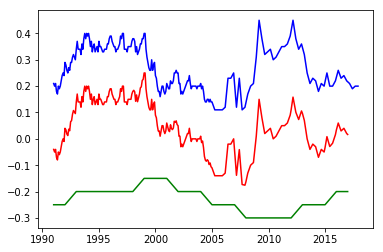

In [89]:
daterange = list(frange(1991,len(alamedaHAI)/12 + 1991,1/12))
plt.plot(daterange,alamedaHAI - unemployment*5, color='red')
plt.plot(daterange,alamedaHAI, color='blue')
plt.plot(daterange,unemployment*(-5), color='green')

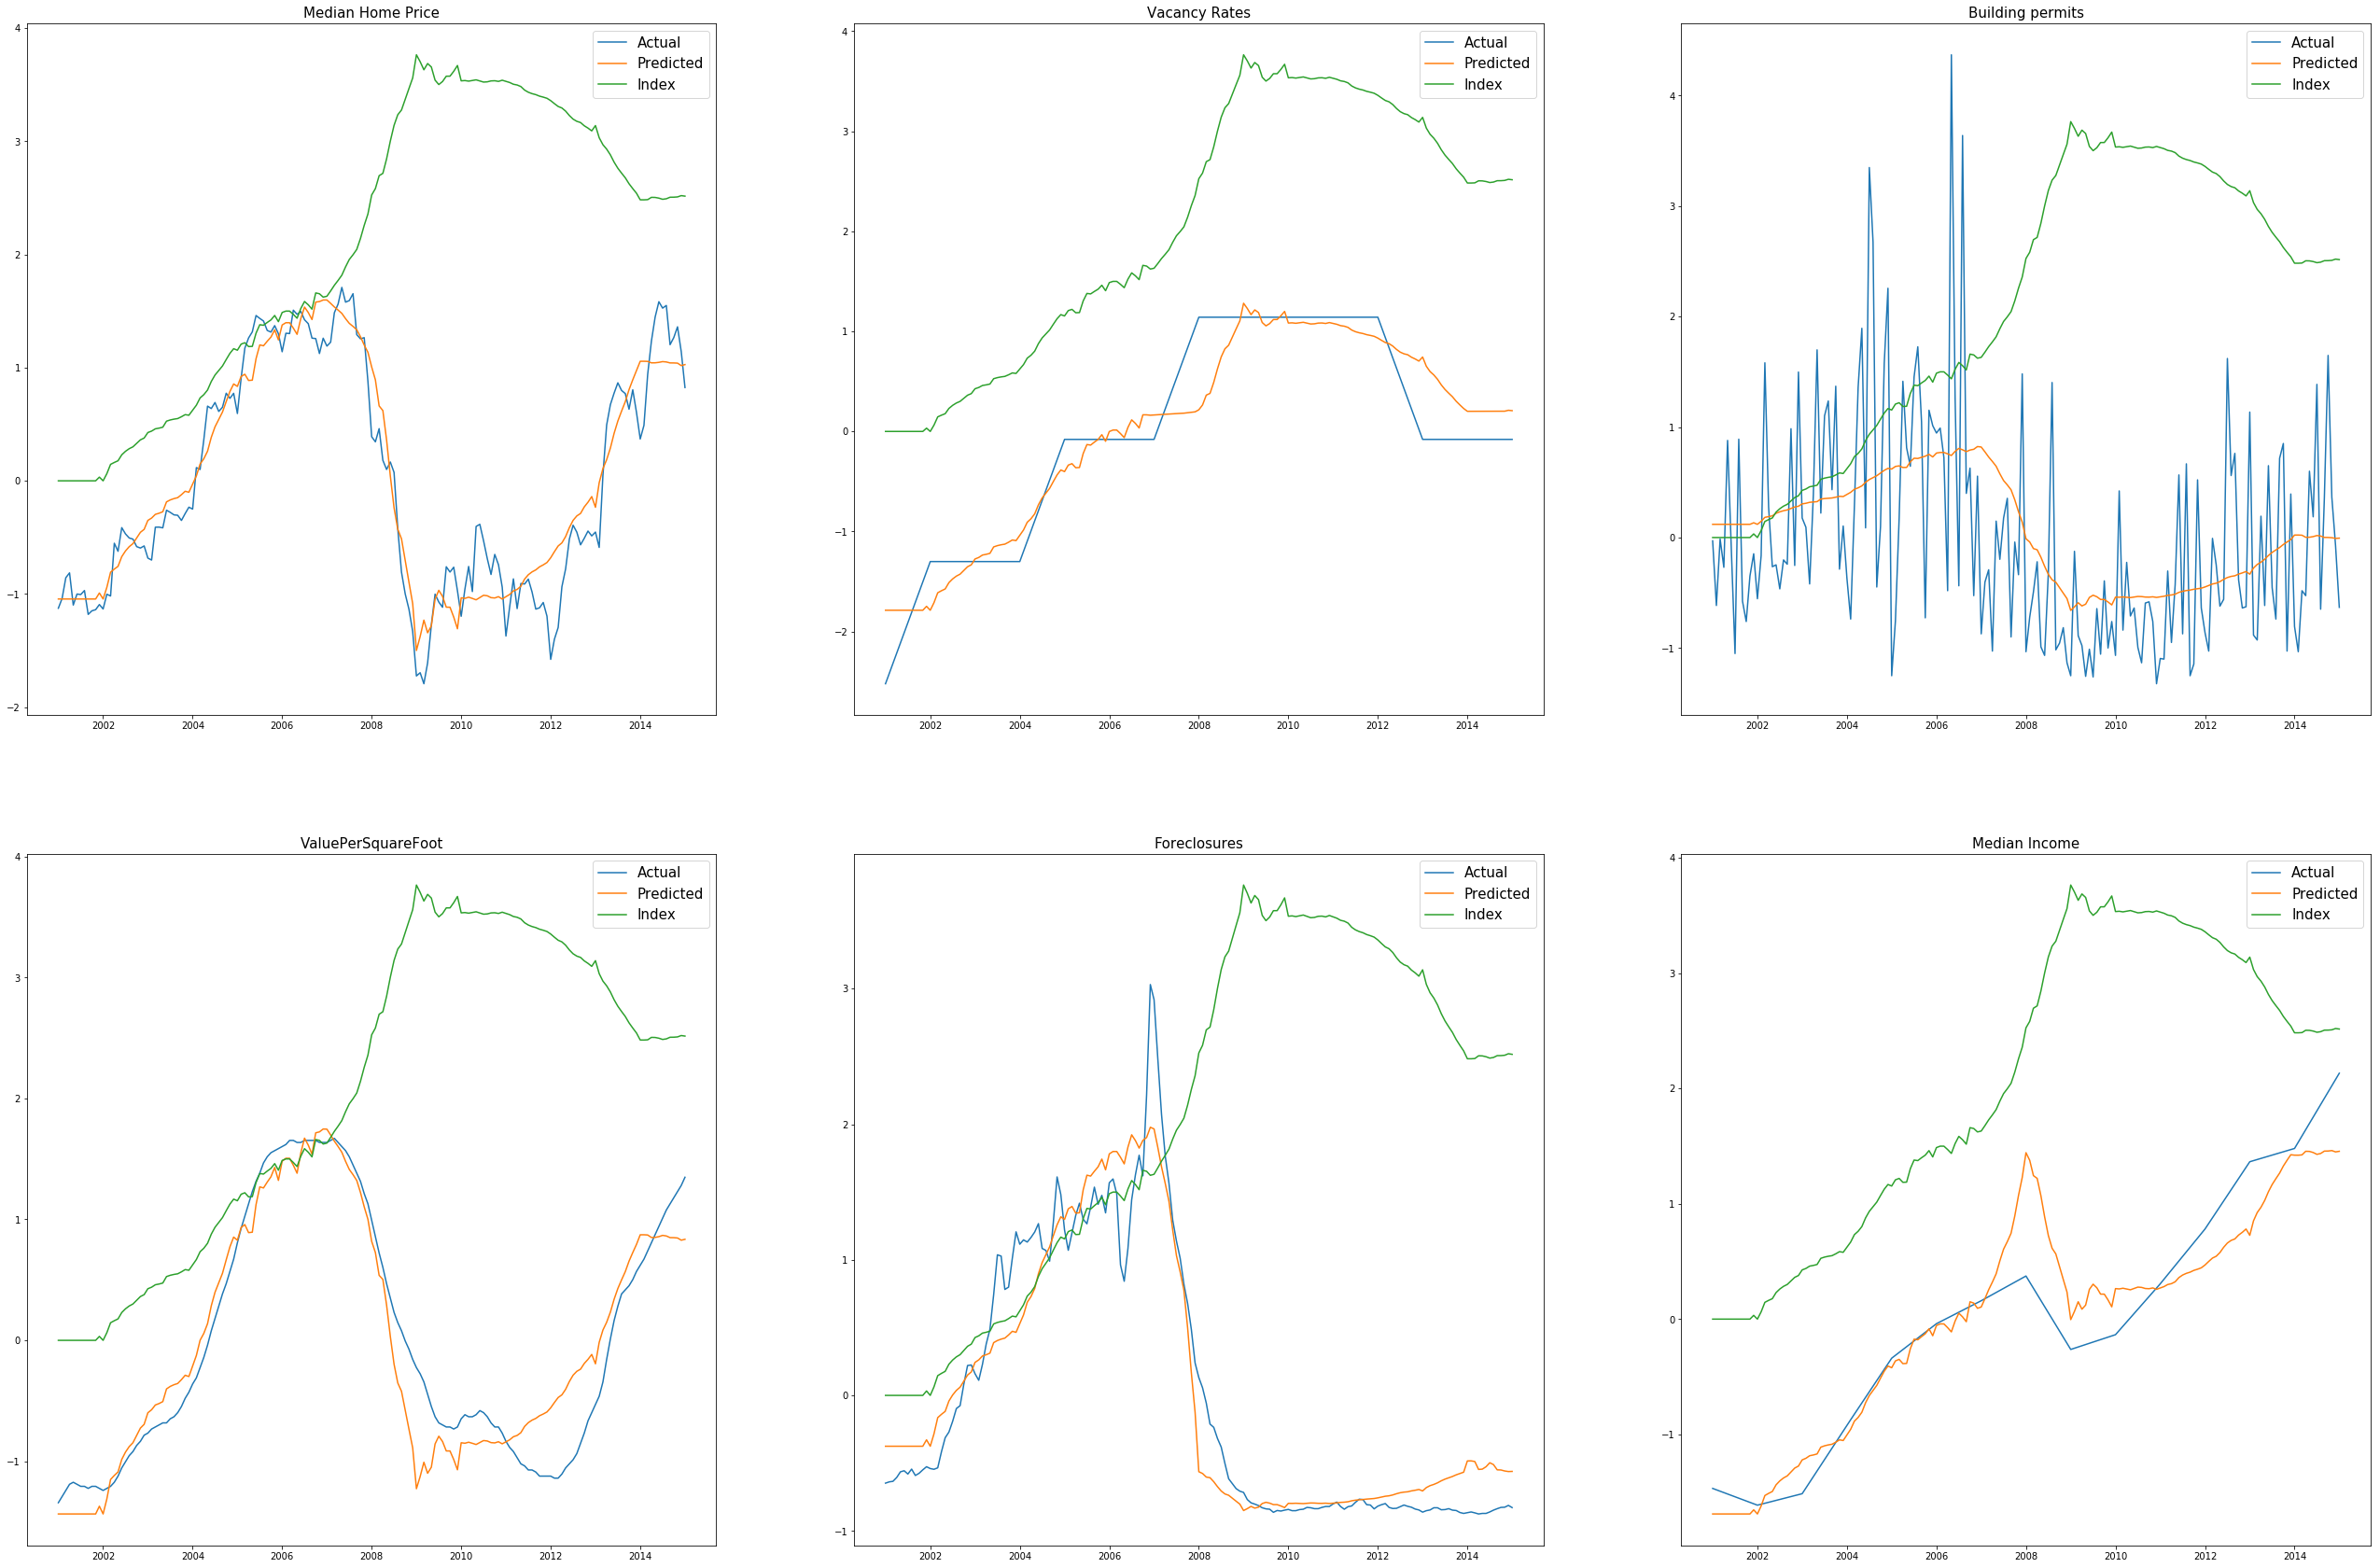

In [61]:

daterange = list(frange(2001,scaled_preds.shape[0]/12 + 2001,1/12))
scale = .7
ax, fig = plt.subplots(nrows = 2, ncols = 3, figsize=(15*3,15*2))
for i in range(6):
    curfig = fig[i//3, i%3]
    curfig.plot(daterange,scaled_preds[:,i])
    curfig.plot(daterange,edmodel.predict(scaled_data)[:,i])
    curfig.plot(daterange,intermediate_layer_model.predict(scaled_data))
    curfig.legend(["Actual", "Predicted", "Index"], prop={'size':15})
    curfig.set_title(names[predinds[i]], size=15)
# for i in range(scaled_data.shape[1]):
#     plt.plot(daterange,model.predict(scale_feature(scaled_data, i, scale)))
# plt.legend(["Actual", "Predicted", "Unemployment", "Gas", "Electricity", "Income", "Population Density"],prop={'size': 15})
# plt.title("Neural network with scaling by " + str(scale), size=18)
# plt.ylabel("Normalized HAI", size=15)
#plt.savefig("IndexPerformance" + timename + ".png")
plt.show()

## Basic linear regression

Unemployment:       -0.11762 - Correlation: +0.290
Gas Consumption:    +0.00744 - Correlation: +0.507
Electricity:        -0.40092 - Correlation: -0.824
Median Income:      -0.98796 - Correlation: -0.890
Population Density: -0.50994 - Correlation: +0.761
Training error: 0.1819172414976146
Test error: 0.20382777571775612
[-1.6224245] [1.86263784]


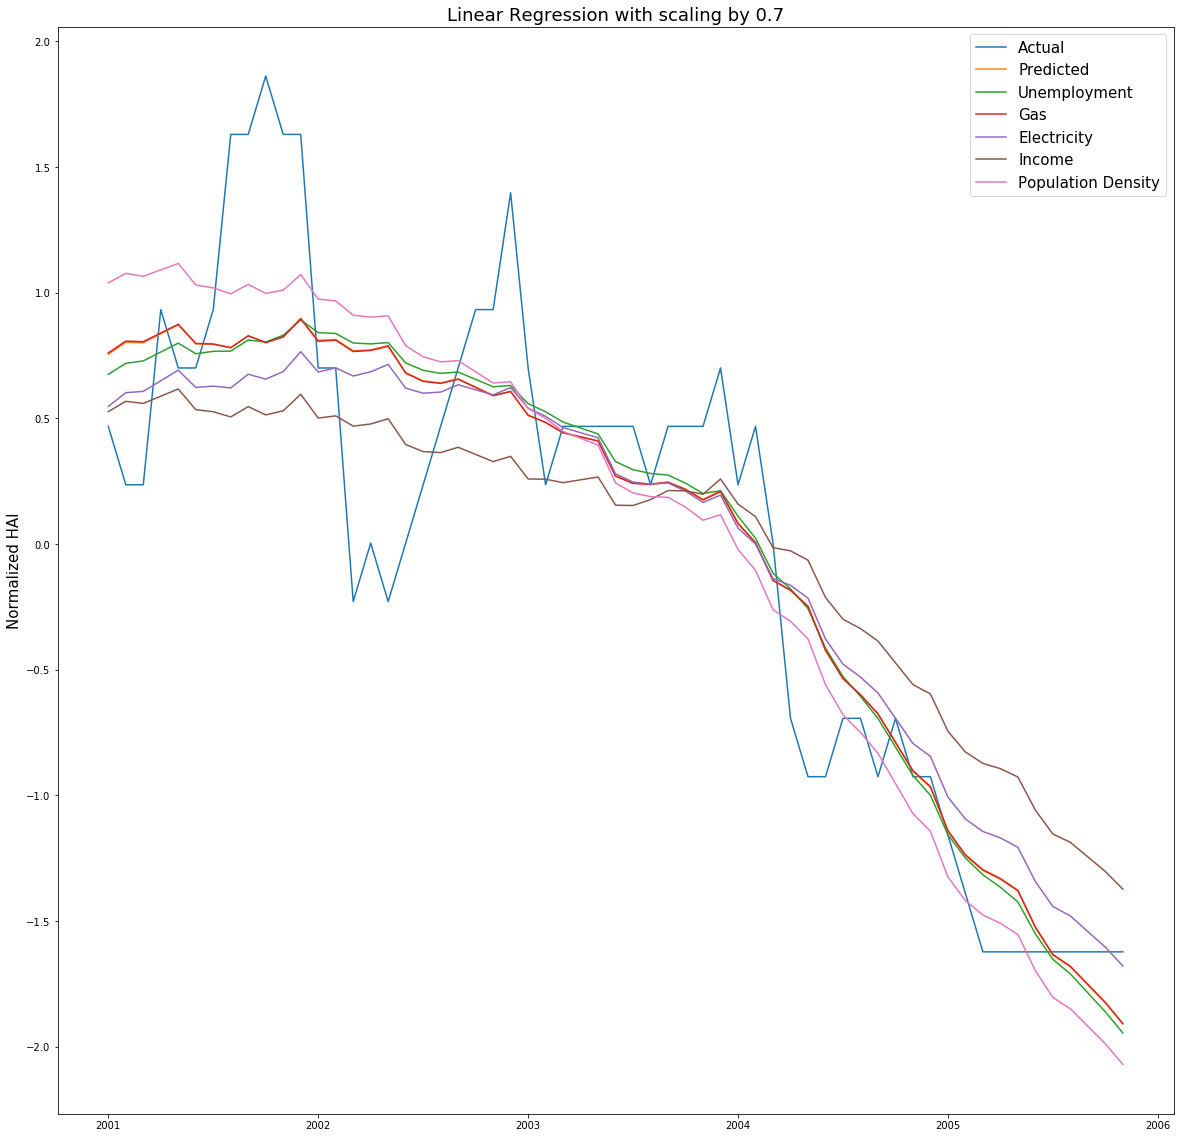

In [66]:
names = ["Median Home Price", "Vacancy Rates", "Building permits", 
"Unemployment", "ValuePerSquareFoot", "Foreclosures", "Gas Consumption", 
"Electricity", "Median Income", "Population Density"]
hai = alamedaHAI[121:180]
data_points = np.array(county_data[0][132:191,:])
inds = [3,6,7,8,9]
features = data_points[:,inds]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)
haiscaler = StandardScaler()
scaled_hai = scaler.fit_transform(col(hai))
x_train, x_test, y_train, y_test = train_test_split(scaled_data, scaled_hai, test_size=0.2, random_state=0)
w = np.linalg.inv(x_train.T@x_train)@(x_train.T@col(y_train))
for i in range(len(w)):
    corr = pearsonr(data_points[:,inds[i]], hai)[0]
    print("{:19s} {:+1.5f} - Correlation: {:+1.3f}".format(names[inds[i]] + ":", np.asscalar(w[i]), corr))
print("Training error:", np.linalg.norm(x_train@w - y_train)**2/x_train.shape[0])
print("Test error:", np.linalg.norm(x_test@w - y_test)**2/x_test.shape[0])
print(min(scaled_hai), max(scaled_hai))
daterange = list(frange(2001,2006-1/12,1/12))
plt.figure(figsize = (20,20))
plt.plot(daterange,scaled_hai)
plt.plot(daterange,scaled_data@w)
scale = .7
for i in range(scaled_data.shape[1]):
    plt.plot(daterange,scale_feature(scaled_data, i, scale)@w)
plt.legend(["Actual", "Predicted", "Unemployment", "Gas", "Electricity", "Income", "Population Density"],prop={'size': 15})
plt.title("Linear Regression with scaling by " + str(scale), size=18)
plt.ylabel("Normalized HAI", size=15)
plt.savefig("OLSComparison" + str(scale) + ".png")
plt.show()

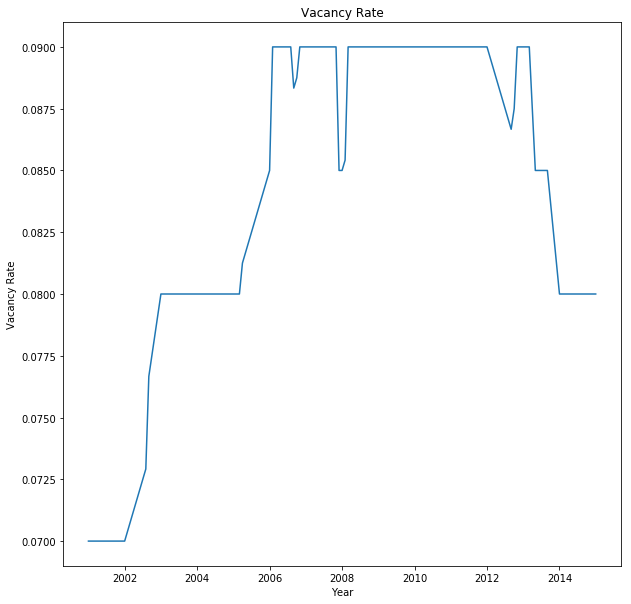

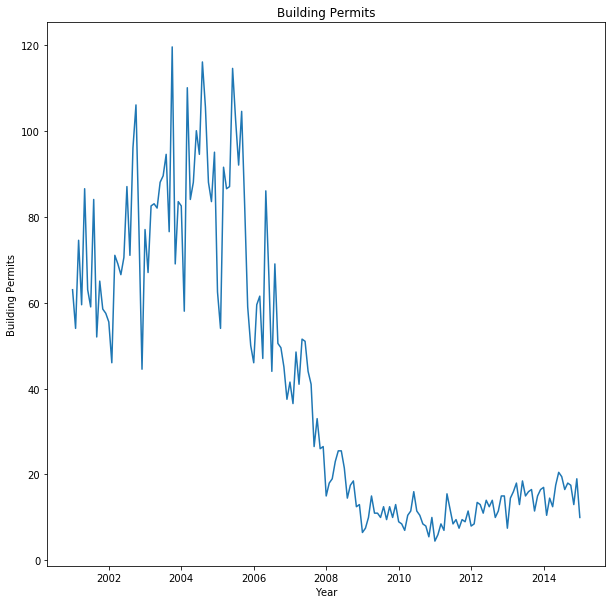

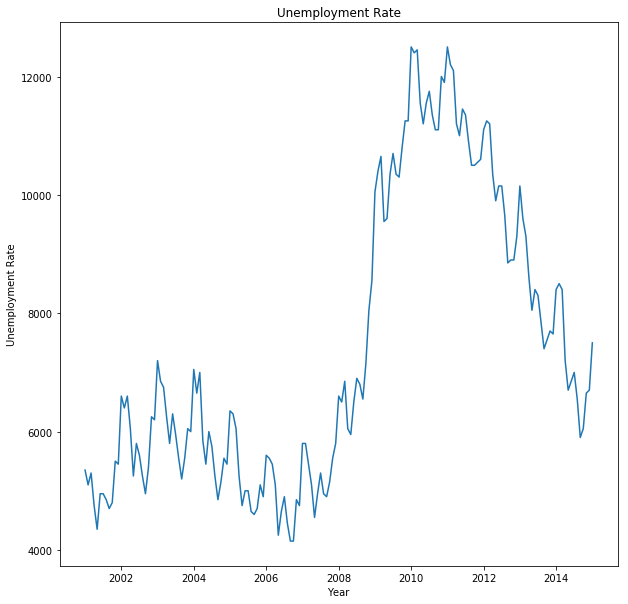

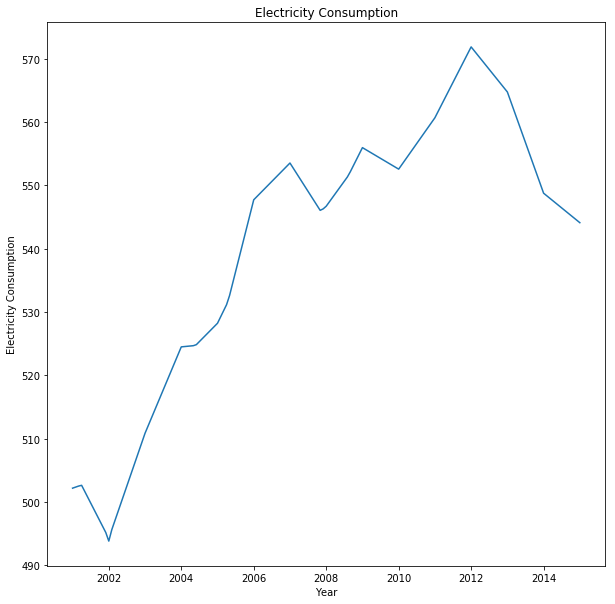

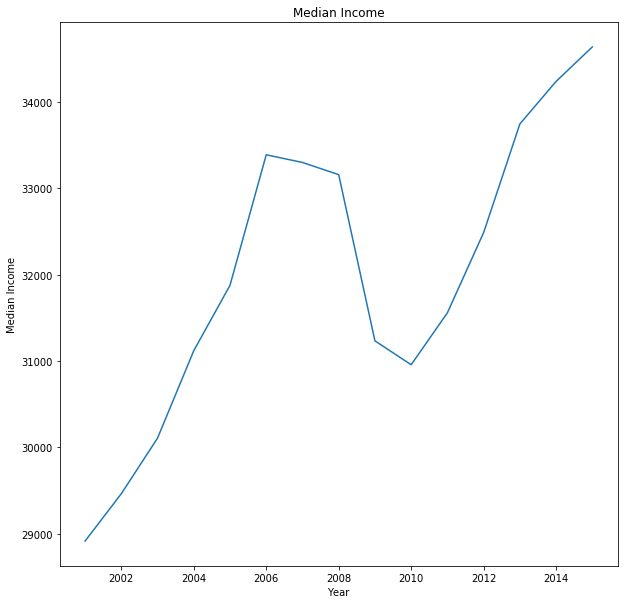

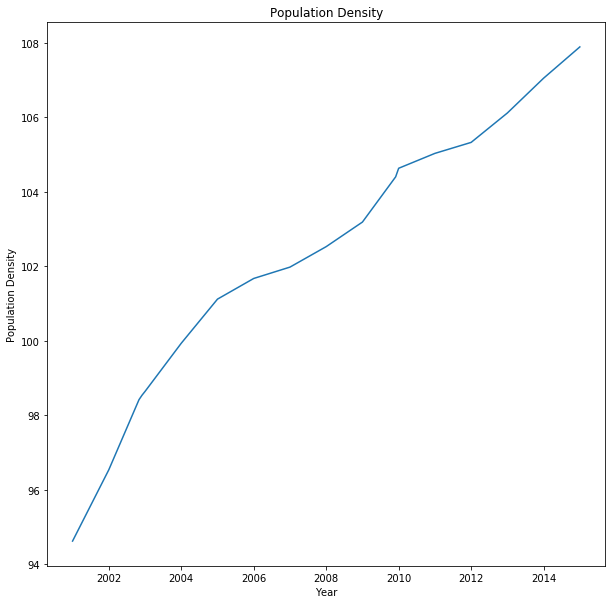

In [267]:
data_points = np.zeros((169,6,58))
for i in range(len(county_data)):
    county = county_data[i]
    data_points[:,:,i] = county[132:301, [1,2,3,7,8,9]]
med = np.median(data_points,axis=2)
names = ["Vacancy Rate", "Building Permits", "Unemployment Rate", "Electricity Consumption", "Median Income", "Population Density"]
daterange = list(frange(2001,2015+1/12,1/12))
for i in range(6):
    plt.figure(figsize=(10,10))
    plt.plot(daterange,med[:,i])
    plt.title(names[i])
    plt.xlabel("Year")
    plt.ylabel(names[i])
    plt.show()

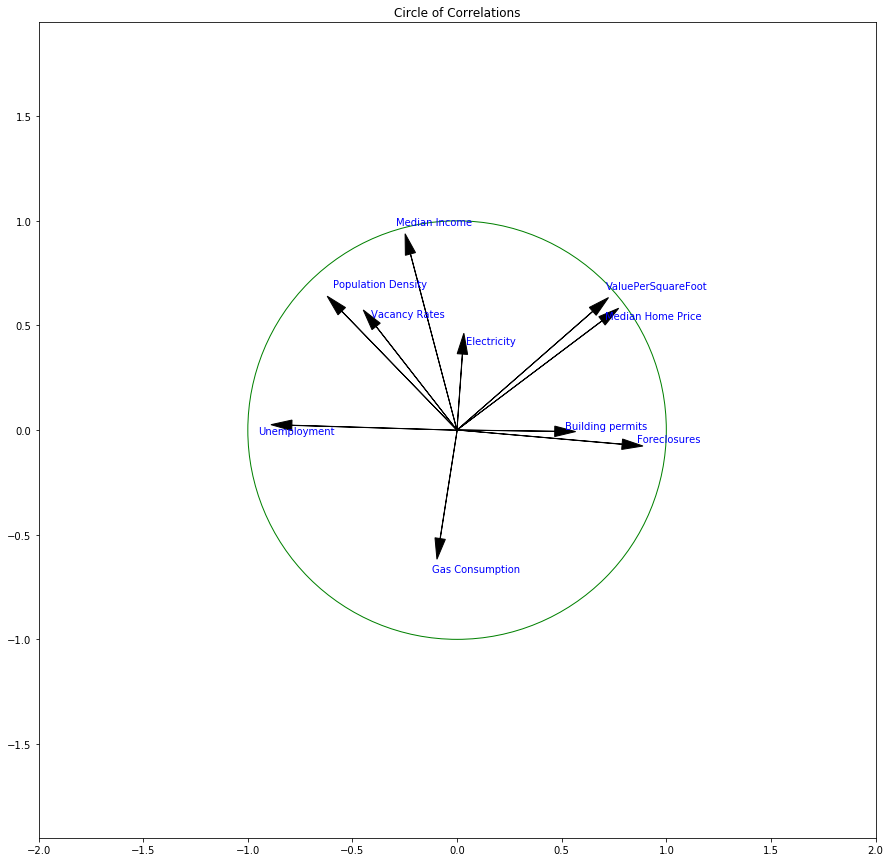

In [364]:
# pca_data = []
# for county in county_data:
#     pca_data.append(county[132:301, [1,2,3,7,8,9]])
# data_points = []
# for county in pca_data:
#     for i in range(county.shape[0]):
#         data_points.append(county[i])
# data_points = np.array(data_points)
# names = ["Vacancy Rates", "Building Permits", "Unemployment", "Electricity", "Median Income", "Population Density"]

names = ["Median Home Price", "Vacancy Rates", "Building permits", 
"Unemployment", "ValuePerSquareFoot", "Foreclosures", "Gas Consumption", 
"Electricity", "Median Income", "Population Density"]
data_points = county_data[0][132:301,:]

# names = ["Vacancy Rates", "Building permits", 
# "Unemployment", "ValuePerSquareFoot", "Foreclosures", "Gas Consumption", 
# "Electricity", "Population Density"]
# data_points = np.array(county_data[0][132:301,[1,2,3,4,5,6,7,9]])

scaler = StandardScaler()
data_points = scaler.fit_transform(data_points)
pca = PCA(n_components=2)
pca.fit(data_points)
plt.figure(figsize = (15,15))
plt.Circle((0,0),radius=10, color='g', fill=False)
circle1=plt.Circle((0,0),radius=1, color='g', fill=False)
fig = plt.gcf()
fig.gca().add_artist(circle1)
plt.axis('equal')
pca_coords = pca.transform(data_points)
for i in range(data_points.shape[1]):
    c1 = pearsonr(pca_coords[:,0], data_points[:,i])[0]
    c2 = pearsonr(pca_coords[:,1], data_points[:,i])[0]
    plt.arrow(0,0,c1,c2,head_width=0.05, head_length=0.1, fc='k', ec='k',length_includes_head=True)
    plt.annotate(names[i], xy=(c1 + (random()-.5)/7,c2 + (random()-.5)/7), color="blue")
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.title("Circle of Correlations")
plt.savefig('AlamedaCircle.png', bbox_inches='tight')
plt.show()

In [202]:
pca2 = PCA(n_components=data_points.shape[1])
pca2.fit(data_points)
pca2.explained_variance_ratio_

array([  3.68041082e-01,   2.96220000e-01,   2.05243487e-01,
         7.62514765e-02,   1.85830388e-02,   1.61830911e-02,
         8.77340063e-03,   8.02141780e-03,   2.35419300e-03,
         3.28813144e-04])

In [331]:
bayArea = ["Alameda", "Contra Costa", "Marin", "Napa", "San Francisco", "San Mateo", "Santa Clara", "Santa Cruz", "Solano", "Sonoma"]
socal = "Orange, Riverside, San Bernardino, San Diego, Santa Barbara, Ventura".split(", ") + ["Los Angeles"]
centralsouthern = "Fresno, Imperial, Kern, Kings, Madera, Merced, Monterey, San Benito, San Joaquin, San Lois Obispo, Stanislaus, Tulare".split(", ")
north = "Alpine, Amador, Butte, Calaveras, Del Norte, Glenn, Humboldt, Inyo, Lake, Lassen, Mariposa,Mendocino, Modoc, Mono, Nevada, Plumas, Shasta, Sierra, Siskiyou, Tehama, Trinity, Tuolumne".split(", ")
centralValley = "Colusa, El Dorado, Placer, Sacramento, Sutter, Yolo, Yuba".split(", ")
regions = [bayArea, socal, centralsouthern, north, centralValley]
regionNames = ["Bay Area", "Southern California", "Central/Southern Farm", "North and Mountain", "Central Valley"]


['Orange', 'Riverside', 'San Bernardino', 'San Diego', 'Santa Barbara', 'Ventura', 'Los Angeles']


In [375]:
for month in ["January", "February", "April"]:
    print("{:>20}".format(month + "2005"))

         January2005
        February2005
           April2005


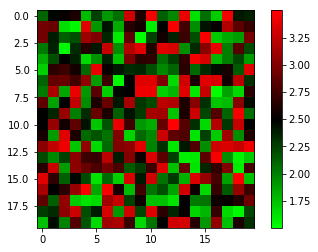

In [376]:
from numpy.random import rand
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

cdict = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),
         'blue':  ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),
         'green': ((0.0, 0.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))}

cmap = mcolors.LinearSegmentedColormap(
'my_colormap', cdict, 100)

ax = plt.subplot(111)
im = ax.imshow(2*rand(20, 20) + 1.5, cmap=cmap)
plt.colorbar(im)
plt.show()

In [430]:
def sqrt(x):
    signs = np.abs(x)/x
    pos = np.sqrt(np.abs(x))
    return signs * pos

In [481]:
print(counties)

['Alameda', 'Alpine', 'Amador', 'Butte', 'Calaveras', 'Colusa', 'Contra Costa', 'Del Norte', 'El Dorado', 'Fresno', 'Glenn', 'Humboldt', 'Imperial', 'Inyo', 'Kern', 'Kings', 'Lake', 'Lassen', 'Los Angeles', 'Madera', 'Marin', 'Mariposa', 'Mendocino', 'Merced', 'Modoc', 'Mono', 'Monterey', 'Napa', 'Nevada', 'Orange', 'Placer', 'Plumas', 'Riverside', 'Sacramento', 'San Benito', 'San Bernardino', 'San Diego', 'San Francisco', 'San Joaquin', 'San Luis Obispo', 'San Mateo', 'Santa Barbara', 'Santa Clara', 'Santa Cruz', 'Shasta', 'Sierra', 'Siskiyou', 'Solano', 'Sonoma', 'Stanislaus', 'Sutter', 'Tehama', 'Trinity', 'Tulare', 'Tuolumne', 'Ventura', 'Yolo', 'Yuba']


In [527]:
pca.components_

array([[-0.45213684,  0.36020594, -0.3525088 , -0.43117821, -0.39469608,
        -0.44705912]])

['Vacancy Rates:-0.518', 'Building Permits:0.249', 'Unemployment:-0.408', 'Electricity:-0.328', 'Median Income:-0.465', 'Population Density:-0.424']
Alameda [ 0.76370254]
['Vacancy Rates:-0.518', 'Building Permits:0.249', 'Unemployment:-0.408', 'Electricity:-0.328', 'Median Income:-0.465', 'Population Density:-0.424']
Contra Costa [ 0.58631324]
['Vacancy Rates:-0.518', 'Building Permits:0.249', 'Unemployment:-0.408', 'Electricity:-0.328', 'Median Income:-0.465', 'Population Density:-0.424']
Fresno [ 0.82660573]
['Vacancy Rates:-0.518', 'Building Permits:0.249', 'Unemployment:-0.408', 'Electricity:-0.328', 'Median Income:-0.465', 'Population Density:-0.424']
Los Angeles [ 0.86004249]
['Vacancy Rates:-0.518', 'Building Permits:0.249', 'Unemployment:-0.408', 'Electricity:-0.328', 'Median Income:-0.465', 'Population Density:-0.424']
Marin [ 0.79195196]
['Vacancy Rates:-0.518', 'Building Permits:0.249', 'Unemployment:-0.408', 'Electricity:-0.328', 'Median Income:-0.465', 'Population Density

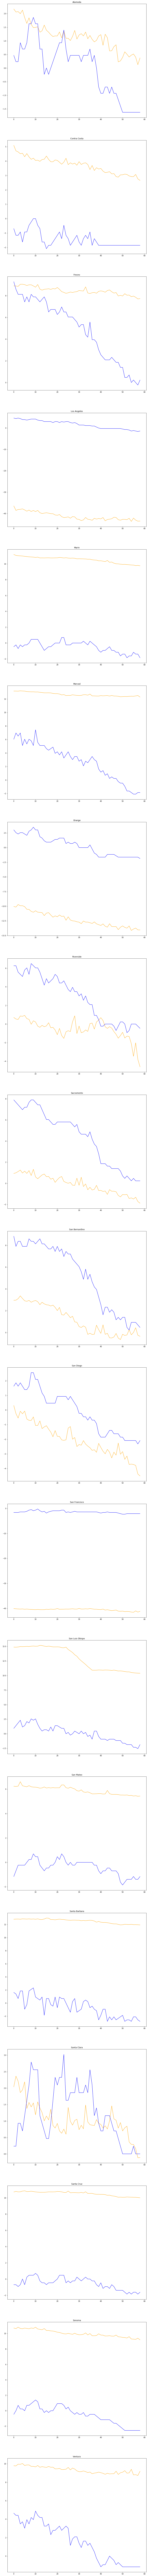

In [541]:
pca_data = []
for county in county_data:
    pca_data.append(county[132:301, [1,2,3,7,8,9]])
data_points = []
for county in pca_data:
    for i in range(county.shape[0]):
        data_points.append(county[i])
hai_names = "Alameda	Amador	Butte	Contra Costa	El Dorado	Fresno	Humboldt	Kern	Kings	Lake	Los Angeles	Madera	Marin	Mariposa	Mendocino	Merced	Monterey	Napa	Orange	Placer	Riverside	Sacramento	San Benito	San Bernardino	San Diego	San Francisco	San Joaquin	San Luis Obispo	San Mateo	Santa Barbara	Santa Clara	Santa Cruz	Shasta	Siskiyou	Solano	Sonoma	Stanislaus	Sutter	Tehama	Tulare	Ventura	Yolo	Yuba"
hai_names = hai_names.split("	")
valid_inds = []
for i in range(len(hai_names)):
    if not any(np.isnan(hai[:,i])):
        valid_inds.append(i)
fig,ax = plt.subplots(nrows = 19, figsize=(15,19*15))
scaler = StandardScaler()
pca = PCA(n_components = 1)
base = county_data[counties.index(hai_names[valid_inds[0]])][132:301,[1,2,3,7,8,9]]
scaled_base = scaler.fit_transform(base)
transformed_base = pca.fit_transform(scaled_base)
output_scaler = StandardScaler()
output_scaler.fit(transformed_base)
hai_scaler = StandardScaler()
hai_scaler.fit(col(hai[121:180,valid_inds[0]]))
for i in range(len(valid_inds)):
    ind = valid_inds[i]
    data_points = scaler.transform(county_data[counties.index(hai_names[ind])][132:301,[1,2,3,7,8,9]])
    
    transformed = pca.transform(data_points)
    print([["Vacancy Rates", "Building Permits", "Unemployment", "Electricity", "Median Income", "Population Density"][i] + ":" + "{:.3}".format(float(pca.components_[0,i])) for i in range(6)])
    scaledtransformed = output_scaler.transform(transformed[0:59])
    cur_hai = hai[:,ind]
    scaledhai = hai_scaler.transform(col(cur_hai[121:180]))
    print(hai_names[ind],pearsonr(scaledtransformed,scaledhai)[0])
    ax[i].plot(scaledtransformed, color='orange')
    ax[i].plot(scaledhai, color='blue')
    ax[i].set_title(hai_names[ind])
gs.update(left=0.05, right=0.48, wspace=0.05)
plt.savefig('bigpic.png', bbox_inches='tight')
plt.show()

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
The animation has finished.


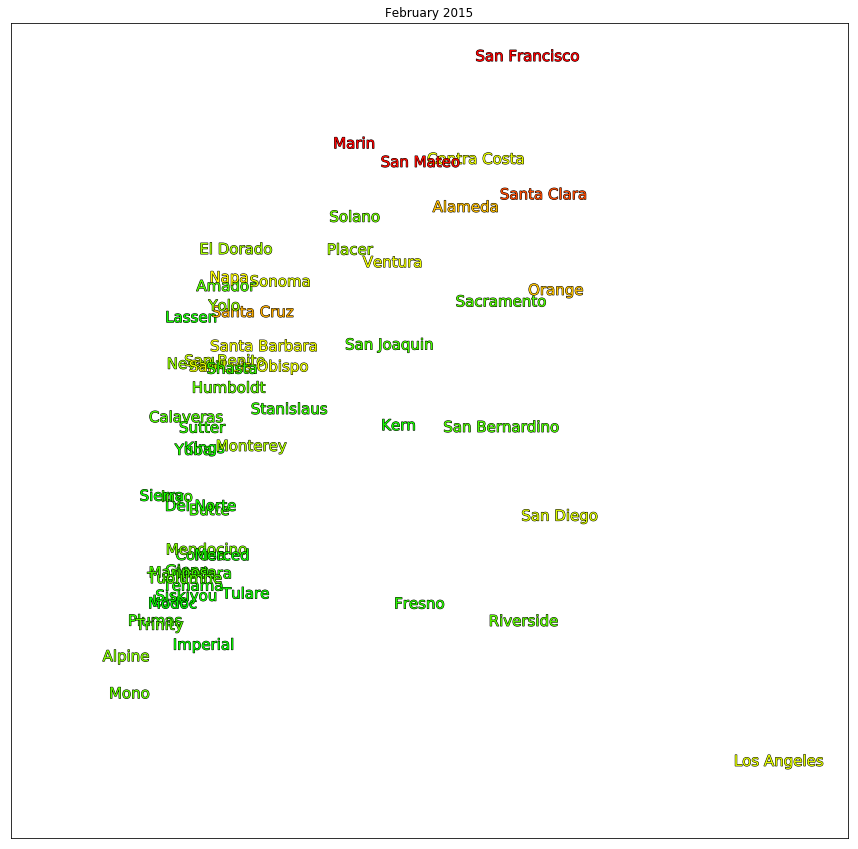

In [435]:
from matplotlib.colors import LinearSegmentedColormap
cdict1 = {'red':   ((0.0, 0.0, 0.0),
                 (0.5, 1.0,1.0),
        (1, 1.0,1.0)),

       'green': ((0.0, 1.0, 1.0),
        (0.5, 1.0, 1.0),
                 (1.0, 0.0, 0.0)),

       'blue':  ((0.0, 0.0, 0.0),
                 (1.0, 0.0, 0.0))
      }
red_green = LinearSegmentedColormap('RedGreen', cdict1)
pca_data = []
for county in county_data:
    pca_data.append(county[132:301, [1,2,3,7,8,9]])
fig, ax = plt.subplots(figsize=(15,15))
dots, = ax.plot([], [], 'bo', ms=6)
ax.set_ylabel("Rental Price")
ann_list = [0 for _ in range(len(pca_data))]
scaler = StandardScaler()
pca = PCA(n_components=2)
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
cmap = red_green
low = min(householdCosts)
high = max(householdCosts)
def safe_remove(ann):
    if ann != 0:
        ann.remove()
def init():
    dots.set_data([], [])
#     ax.set_xlim([-2,5.5])
#     ax.set_ylim([-2.5,5.5])
    ax.set_xlim([-2,4])
    ax.set_ylim([-2,2.5])
    
    data_points = []
    for county in pca_data:
        for i in range(county.shape[0]):
            data_points.append(county[i])
    data_points = scaler.fit_transform(data_points)
    pca.fit(data_points)
    return (dots,)
def get_color(i):
    householdCost = householdCosts[i]
    return cmap(int((householdCost - low)/(high - low) * 256))
def update(i):
    title = str(months[(i + 1) % 12]) + " " + str(i // 12 + 2001)
    if i % 12 == 0:
        print(i // 12 + 2001)
    # ML stuff
    data_points = []
    data_list = pca_data
    ## COLLECT RELEVANT DATA FROM THE DATA_LIST
    for county in data_list:
        data_points.append(county[i]) # row of everything including month    
    ## PCA
    transformed_data = sqrt(pca.transform(scaler.transform(data_points)))

    ## PLOT
#     dots.set_data(transformed_data[:,0], transformed_data[:,1])
    
    
    # Update the line and the axes (with a new xlabel). Return a tuple of
    # "artists" that have to be redrawn for this frame.
    for i in range(len(counties)):
        safe_remove(ann_list[i])
        txt = ax.annotate(counties[i], (transformed_data[i,0], transformed_data[i,1]), color=get_color(i), fontsize=15)
        txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='k')])
        ann_list[i] = txt
    if i == 0:
        ax.margins(.05)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(title)
    return dots, ax


# anim = FuncAnimation(fig, update, init_func = init, frames=1, interval=150)

anim = FuncAnimation(fig, update, init_func = init, frames=pca_data[0].shape[0], interval=50)

anim.save("PCAfast.gif", dpi=80, writer='imagemagick')
print("The animation has finished.")

In [110]:
class LSTM:
    def __init__(self, num_outs=1, learning_rate=.001, display_step=1000, n_input=4, num_test_years=5, n_hidden=5):
        self.num_outs = num_outs
        self.learning_rate = learning_rate
        self.display_step = display_step
        self.n_input = n_input
        self.num_test_years = num_test_years
        self.n_hidden = n_hidden
        self.weights = {
        'out': tf.Variable(tf.random_normal([self.n_hidden, self.num_outs], dtype=tf.float32))
        }
        self.biases = {
        'out': tf.Variable(tf.random_normal([self.num_outs],dtype=tf.float32))
        }
        self.x_mean = tf.Variable([0]*self.n_input,dtype=tf.float32)
        self.y_mean = tf.Variable([0]*self.num_outs, dtype=tf.float32)
        self.x_var = tf.Variable([0]*self.n_input, dtype=tf.float32)
        self.y_var = tf.Variable([0]*self.num_outs, dtype=tf.float32)
        self.x_scale = tf.Variable([0]*self.n_input, dtype=tf.float32)
        self.y_scale = tf.Variable([0]*self.num_outs, dtype=tf.float32)
        
        self.x = tf.placeholder("float", [None, self.n_input])
        self.y_ = tf.placeholder("float", [None, self.num_outs])
        self.x_scaler = StandardScaler()
        self.y_scaler = StandardScaler()
        self.standard_pred = self.RNN(self.x, self.weights, self.biases)
        self.cost = tf.reduce_mean(tf.losses.mean_squared_error(self.y_, 
                                                                self.standard_pred))
        
        self.scalersInitialized = False
        """
        Cost takes in unstandardized data
        Pred takes in and returns standardized data
        """
        self.optimizer = tf.train.AdadeltaOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        tf.global_variables_initializer().run()
    
    def normalize(self, data):
        mean = np.mean(data, axis=0)
        stdev = np.std(data, axis=0)
        data = (data - mean)/(stdev+10**-6)
        def renorm(data2):
            return (data2-mean)/(stdev+10**-6)
        def unnorm(data3):
            return data3*(stdev+10**-6)+mean
        return data, renorm, unnorm
    
    def RNN(self, x, weights, biases):
        # reshape to [1, n_input]
        x = tf.reshape(self.x, [-1, self.n_input])

        # Generate a n_input-element sequence of inputs
        # (eg. [had] [a] [general] -> [20] [6] [33])
        x = tf.split(x, self.n_input,1)

        # 2-layer LSTM, each layer has n_hidden units.
        rnn_cell = rnn.MultiRNNCell([rnn.BasicLSTMCell(self.n_hidden),rnn.BasicLSTMCell(self.n_hidden)])

        # 1-layer LSTM with n_hidden units but with lower accuracy.
        # Average Accuracy= 90.60% 50k iter
        # Uncomment line below to test but comment out the 2-layer rnn.MultiRNNCell above
        # rnn_cell = rnn.BasicLSTMCell(n_hidden)

        # generate prediction
        outputs, states = rnn.static_rnn(rnn_cell, x, dtype=tf.float32)

        # there are n_input outputs but
        # we only want the last output
        return tf.matmul(outputs[-1], self.weights['out']) + self.biases['out']
    
    def train(self, x_input, y_input, epochs=5000, print_error=True):
        #Normalize Data
        if not self.scalersInitialized:
            x_standard = self.x_scaler.fit_transform(x_input)
            y_standard = self.y_scaler.fit_transform(y_input)
            self.x_mean = self.x_mean.assign(self.x_scaler.mean_)
            self.y_mean = self.y_mean.assign(self.y_scaler.mean_)
            self.x_var = self.x_var.assign(self.x_scaler.var_)
            self.y_var = self.y_var.assign(self.y_scaler.var_)
            self.x_scale = self.x_scale.assign(self.x_scaler.scale_)          
            self.y_scale = self.y_scale.assign(self.y_scaler.scale_)
            
            # Run the assignment operators
            self.sess.run(self.x_mean)
            self.sess.run(self.x_var)
            self.sess.run(self.x_scale)
            self.sess.run(self.x_scale)
            self.sess.run(self.y_mean)
            self.sess.run(self.y_var)
            self.sess.run(self.y_scale)
            self.scalersInitialized = True
        else:
            x_standard = self.x_scaler.transform(x_input)
            y_standard = self.y_scaler.transform(y_input)
            
        #x_input and y_input are now standardized
        
        n = x_input.shape[0]

        for _ in range(epochs):
            if _ > 0 and _ % self.display_step == 0:
                print("Training error after", _, "epochs:", 
                          self.error(x_input, y_input))
            self.sess.run(self.optimizer, feed_dict={self.x: x_standard, self.y_: y_standard})
        if print_error:
            print("Training error:",self.error(x_input,y_input))
    
    def run(self, x_input):
        return self.y_scaler.inverse_transform(self.sess.run(self.standard_pred, feed_dict = {self.x: self.x_scaler.transform(x_input)}))
    def error(self, x_input, y_input):
        return self.sess.run(self.cost, feed_dict = {self.x: self.x_scaler.transform(x_input), self.y_: self.y_scaler.transform(y_input)})
    def full_pred_error(self, x_input, num_past):
        assert self.num_outs == self.n_input, "Network must have same number of outputs and inputs."
        x_end = x_input[-1*num_past:, :]
        x_start = x_input[:-1*num_past, :]
        preds = self.predict_past(x_start, num_past)
        return self.sess.run(tf.reduce_mean(tf.losses.mean_squared_error(x_end[:,1], preds[:,1])))
    def save(self, filename):
        saver = tf.train.Saver()
        save_path = saver.save(self.sess, filename)
    def load(self, filename):
        saver = tf.train.Saver()
        saver.restore(self.sess, filename)
        self.x_scaler.mean_ = self.sess.run(self.x_mean)
        self.x_scaler.var_ = self.sess.run(self.x_var)
        self.x_scaler.scale_ = self.sess.run(self.x_scale)
        self.x_scaler.scale_ = self.sess.run(self.x_scale)
        self.y_scaler.mean_ = self.sess.run(self.y_mean)
        self.y_scaler.var_ = self.sess.run(self.y_var)
        self.y_scaler.scale_ = self.sess.run(self.y_scale)
        
        self.scalersInitialized = True
    def predict_past(self, x_input, num_past):
        assert self.num_outs == self.n_input, "Network must have same number of outputs and inputs."
        cur_x = row(self.run(x_input)[-1, :])
        preds = cur_x
        for i in range(num_past - 1):
            cur_x = self.run(cur_x)
            preds = np.vstack((preds, cur_x))
        return preds

Loop number 1
Train error: 0.842771
Test error: 8.35345
New best model! Model saved


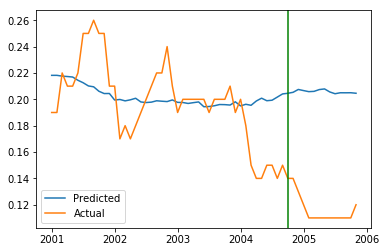

Loop number 2
Train error: 0.77319
Test error: 7.8626
New best model! Model saved


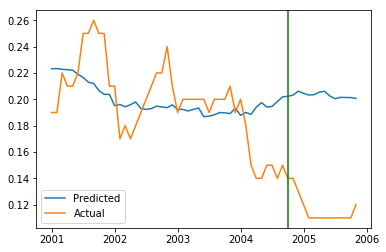

Loop number 3
Train error: 0.714612
Test error: 7.14967
New best model! Model saved


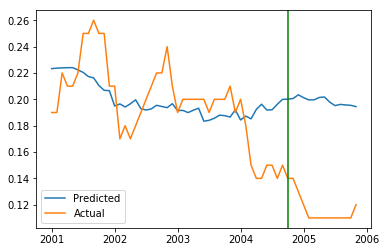

Loop number 4
Train error: 0.573807
Test error: 4.5505
New best model! Model saved


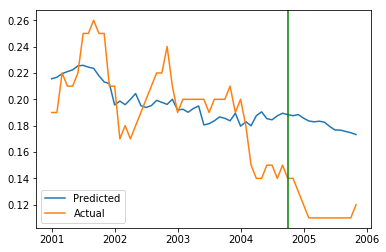

Loop number 5
Train error: 0.273573
Test error: 0.137333
New best model! Model saved


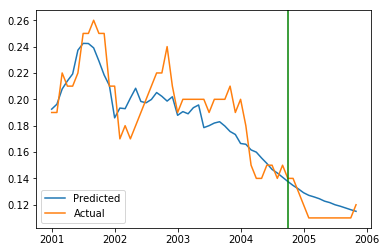

Loop number 6
Train error: 0.174308
Test error: 0.0848638
New best model! Model saved


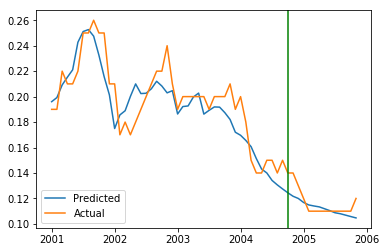

Loop number 7
Train error: 0.143617
Test error: 0.0790058
New best model! Model saved


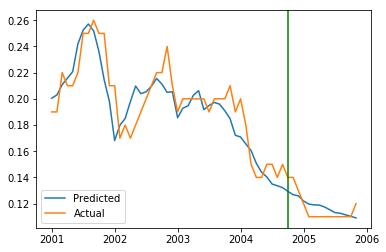

Loop number 8
Train error: 0.129595
Test error: 0.135878
Loop number 9
Train error: 0.121487
Test error: 0.251978
Loop number 10
Train error: 0.116043
Test error: 0.424606
Loop number 11
Train error: 0.11176
Test error: 0.662727
Loop number 12
Train error: 0.107867
Test error: 0.978564
Loop number 13
Train error: 0.10403
Test error: 1.36293
Loop number 14
Train error: 0.10017
Test error: 1.78039
Loop number 15
Train error: 0.0963686
Test error: 2.18922
Loop number 16
Train error: 0.0927939
Test error: 2.56038
Loop number 17
Train error: 0.0897381
Test error: 2.88161
Loop number 18
Train error: 0.0873084
Test error: 3.1519
Loop number 19
Train error: 0.0849825
Test error: 3.38193
Loop number 20
Train error: 0.0825692
Test error: 3.58334
Loop number 21
Train error: 0.0800705
Test error: 3.76702
Loop number 22
Train error: 0.0774634
Test error: 3.94017
Loop number 23
Train error: 0.0748086
Test error: 4.10302
Loop number 24
Train error: 0.0721387
Test error: 4.24851
Loop number 25
Train e

0

In [436]:
tf.reset_default_graph()
num_test = 15
full_pred_LSTM = LSTM(num_outs=1, n_input=5, num_test_years=num_test, n_hidden=10, learning_rate=.05)
hai = col(alamedaHAI[121:180])
data_points = np.array(county_data[0][132:191,:])
inds = [3,6,7,8,9]
features = data_points[:,inds]
train_x = features[:-1*num_test-1,:]
train_y = hai[1:-1*num_test]
test_x = features[-1*num_test-1:-1,:]
test_y = hai[-1*num_test:]
filename = "Models/Alameda.ckpt"
best_error = 10**9
test_errors = []
train_errors = []
date_range = list(frange(2001, 2006-1/12,1/12))
for i in range(50):
    print("Loop number", i+1)
    full_pred_LSTM.train(train_x, train_y, epochs=500, print_error=False)
    train_error = full_pred_LSTM.error(train_x, train_y)
    test_error = full_pred_LSTM.error(test_x, test_y)
    train_errors.append(train_error)
    test_errors.append(test_error)
    print("Train error:", train_error)
    print("Test error:", test_error)
    if test_error < best_error:
        best_error = test_error
        full_pred_LSTM.save(filename)
        print("New best model! Model saved")
        pred_hai = full_pred_LSTM.run(features)
        plt.plot(date_range, pred_hai)
        plt.plot(date_range, hai)
        plt.axvline(2006-num_test/12, color='g')
        plt.legend(["Predicted", "Actual"])
        plt.show()
os.system('say "Finished."')

In [125]:

dat = county_data[counties.index("Alameda")]
county = dat[132:301,:]
num_test = 5
train_x = county[:-1*num_test-1,:]
train_y = county[1:-1*num_test, :]
test_x = county[-1*num_test-1:-1,:]
test_y = county[-1*num_test:,:]
filename = "Models/Alameda.ckpt"
best_error = 10**9
test_errors = []
train_errors = []
all_x = county[:-1, :]
date_range = list(frange(2001, 2015,1/12))
for i in range(50):
    print("Loop number", i+1)
    full_pred_LSTM.train(train_x, train_y, epochs=500, print_error=False)
    train_error = full_pred_LSTM.error(train_x, train_y)
    test_error = full_pred_LSTM.full_pred_error(all_x,num_test)
    train_errors.append(train_error)
    test_errors.append(test_error)
    print("Train error:", train_error)
    print("Test error:", test_error)
    if test_error < best_error:
        best_error = test_error
        full_pred_LSTM.save(filename)
        print("New best model! Model saved")
        result = np.vstack((full_pred_LSTM.run(all_x[:-1*num_test,:]), 
                            full_pred_LSTM.predict_past(all_x[:-1*num_test,:],num_test)))
        plt.plot(date_range, result[:,8]/result[:,0])
        plt.plot(date_range, county[1:,8] / county[1:,0])
        plt.axvline(2015-num_test+1, color='g')
        plt.legend(["Predicted", "Actual"])
        plt.show()
os.system('say "Finished."')

Loop number 1


KeyboardInterrupt: 

In [215]:
full_pred_LSTM.predict_past(all_x, 15)[:,4]

array([ 0.48017579,  0.70516634,  0.81493032,  0.83274168,  0.83111155,
        0.7194168 ,  0.51091999,  0.31222832,  0.19188046,  0.15871853,
        0.18810654,  0.25458002,  0.34228307,  0.4415285 ,  0.54478097], dtype=float32)

In [9]:
desired_countries = ["Sudan", "Argentina", "Guatemala", "Benin", "Nigeria", "Tunisia", "United States", "China"]
desired_countries2 = ["Nigeria", "Tunisia", "United States", "China"]
num_test_years = 5
pred_dict = {}
for country_name in desired_countries:
    tf.reset_default_graph()
    full_pred_LSTM = LSTM(num_outs=5, n_input=5, num_test_years=5, n_hidden=20, learning_rate=.05)
    print("Training on", country_name)
    country = country_data[countries.index(country_name)]
    train_x = country[:-1*num_test_years-1,:]
    train_y = country[1:-1*num_test_years, :]
    test_x = country[-1*num_test_years-1:-1,:]
    test_y = country[-1*num_test_years:,:]
    filename = "Models/full_" + country_name + "LSTM.ckpt"
    best_error = 1000
    test_errors = []
    train_errors = []
    all_x = country[:-1, :]
    for i in range(150):
        
        full_pred_LSTM.train(train_x, train_y, epochs=500, print_error=False)
        train_error = full_pred_LSTM.error(train_x, train_y)
        test_error = full_pred_LSTM.full_pred_error(all_x,num_test_years)
        train_errors.append(train_error)
        test_errors.append(test_error)
        if (i + 1) % 10 == 0:
            print("Loop number", i+1)
            print("Train error:", train_error)
            print("Test error:", test_error)
        if test_error < best_error:
            best_error = test_error
            full_pred_LSTM.save(filename)
            pred_dict[country_name] = full_pred_LSTM.predict_past(country, 15)[:,4]
            print("New best model! Model saved")
#             plt.plot(list(range(1961, 2016)), np.vstack((full_pred_LSTM.run(all_x[:-1*num_test_years,:]),
#                                                          full_pred_LSTM.predict_past(all_x[:-1*num_test_years,:], 
#                                                                                      num_test_years)))[:,4])
#             plt.plot(list(range(1961, 2016)), col(country[1:,4]))
#             plt.axvline(2016-num_test_years+1, color='g')
#             plt.legend(["Predicted", "Actual"])
#             plt.show()

Training on Sudan
New best model! Model saved
New best model! Model saved
Loop number 10
Train error: 0.0172185
Test error: 0.0424705
Loop number 20
Train error: 0.0106151
Test error: 0.056273
Loop number 30
Train error: 0.00310775
Test error: 0.116538
Loop number 40
Train error: 0.00208955
Test error: 0.135881
Loop number 50
Train error: 0.00182527
Test error: 0.118671
Loop number 60
Train error: 0.00161209
Test error: 0.101724
Loop number 70
Train error: 0.0013984
Test error: 0.0849311
Loop number 80
Train error: 0.00118896
Test error: 0.0673128
Loop number 90
Train error: 0.000992052
Test error: 0.0479679
Loop number 100
Train error: 0.000818074
Test error: 0.0293671
Loop number 110
Train error: 0.000675476
Test error: 0.0163657
New best model! Model saved
New best model! Model saved
New best model! Model saved
New best model! Model saved
New best model! Model saved
New best model! Model saved
New best model! Model saved
New best model! Model saved
Loop number 120
Train error: 0.000

In [224]:
for country_name in desired_countries:
    print("Evaluating", country_name)
    tf.reset_default_graph()
    full_pred_LSTM = LSTM(num_outs=5, n_input=5, num_test_years=5, n_hidden=20, learning_rate=.05)
    filename = "Models/full_" + country_name + "LSTM.ckpt"
    full_pred_LSTM.load(filename)
    pred_dict[country_name] = full_pred_LSTM.predict_past(country, 15)[:,4]

Evaluating Cuba
INFO:tensorflow:Restoring parameters from Models/full_CubaLSTM.ckpt
Evaluating Costa Rica
INFO:tensorflow:Restoring parameters from Models/full_Costa RicaLSTM.ckpt
Evaluating Korea, Rep.
INFO:tensorflow:Restoring parameters from Models/full_Korea, Rep.LSTM.ckpt
Evaluating Argentina
INFO:tensorflow:Restoring parameters from Models/full_ArgentinaLSTM.ckpt
Evaluating Indonesia
INFO:tensorflow:Restoring parameters from Models/full_IndonesiaLSTM.ckpt
Evaluating United States
INFO:tensorflow:Restoring parameters from Models/full_United StatesLSTM.ckpt
Evaluating United Arab Emirates
INFO:tensorflow:Restoring parameters from Models/full_United Arab EmiratesLSTM.ckpt
Evaluating Somalia
INFO:tensorflow:Restoring parameters from Models/full_SomaliaLSTM.ckpt
Evaluating Qatar
INFO:tensorflow:Restoring parameters from Models/full_QatarLSTM.ckpt


In [10]:
for country_name in desired_countries:
    print(country_name, pred_dict[country_name])

Sudan [ 2.42764521  2.45574188  2.52407408  2.58693814  2.63647437  2.67241144
  2.69709349  2.71342707  2.72397017  2.7306664   2.73487473  2.73750162
  2.73913431  2.74014664  2.74077344]
Argentina [ 1.00233531  1.02130163  1.02655625  1.03060508  1.03326571  1.03518879
  1.03656447  1.03756082  1.0382843   1.03881121  1.03919613  1.03947759
  1.03968358  1.0398345   1.03994513]
Guatemala [ 2.07184744  2.07594371  2.07637119  2.0756855   2.07501912  2.07453227
  2.07419515  2.07396364  2.07380533  2.07369685  2.07362247  2.07357168
  2.07353687  2.07351303  2.07349658]
Benin [ 2.66815591  2.6848917   2.71135998  2.73473549  2.74800539  2.75526571
  2.75965476  2.76249409  2.7643559   2.76557732  2.76638055  2.76691079
  2.76726174  2.76749516  2.76764941]
Nigeria [ 2.67112231  2.6648016   2.67001772  2.67169356  2.67190933  2.67203951
  2.67212176  2.67215848  2.67217588  2.67218518  2.67218995  2.67219234
  2.67219353  2.672194    2.67219448]
Tunisia [ 1.28913188  1.28542757  1.2363

## Single model testing

Loop number 1
Test error: [ 0.80414683]
New best model! Model saved


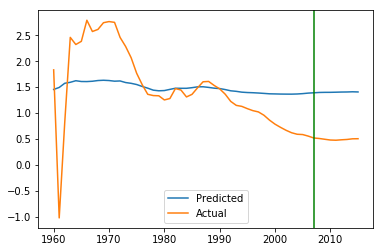

Loop number 2
Test error: [ 0.51172203]
New best model! Model saved


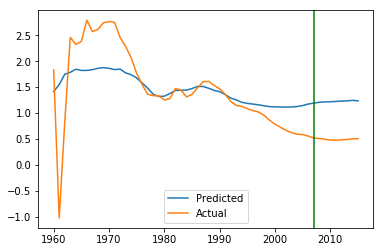

0

In [46]:
tf.reset_default_graph()
#tf.set_random_seed(13)
model = LSTM(display_step=10000, learning_rate=.1)
filename = "/tmp/model.ckpt"
country = country_data[countries.index("China")]
num_test_years=10
all_x = country[:,:4]
train_x = country[:-1*num_test_years,:4]
train_y = col(country[:-1*num_test_years, 4])
test_x = country[-1*num_test_years:,:4]
test_y = col(country[-1*num_test_years:,4])
best_error = 1000
test_errors = []
train_errors = []
for i in range(25):
    print("Loop number", i+1)
    model.train(train_x, train_y, epochs=500, print_error=False)
    train_error = model.error(train_x, train_y)
    test_error = model.error(test_x, test_y)
    train_errors.append(train_error)
    test_errors.append(test_error)
    print("Test error:", test_error)
    if test_error < best_error:
        best_error = test_error
        model.save(filename)
        print("New best model! Model saved")
    plt.plot(list(range(1960, 2016)), model.run(all_x))
    plt.plot(list(range(1960, 2016)), col(country[:,4]))
    plt.axvline(2016-num_test_years+1, color='g')
    plt.legend(["Predicted", "Actual"])
    plt.show()
os.system('say "Finished."')

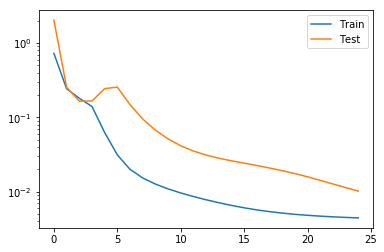

In [227]:
plt.semilogy(list(range(len(train_errors))), train_errors)
plt.semilogy(list(range(len(test_errors))), test_errors)
plt.legend(["Train", "Test"])

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


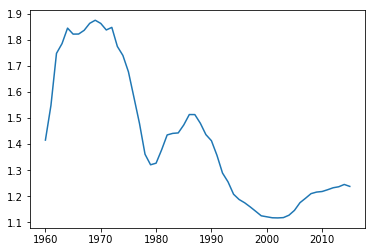

In [47]:
tf.reset_default_graph()
filename = "/tmp/model.ckpt"
model = LSTM(display_step=10000, learning_rate=.1)
model.load(filename)
plt.plot(list(range(1960, 2016)), model.run(all_x))

## Training and saving all models

In [61]:
full_countries = [countries[i] for i in range(len(countries)) if len(country_data[i]) == 56]
full_country_data = [country for country in country_data if len(country) == 56]
num_test_years=10

best_errors = []
for i in range(len(full_countries)):
    country = full_country_data[i]
    country_name = countries[i]
    filename = "Models/" + country_name + "LSTM.ckpt"
    tf.reset_default_graph()
    #tf.set_random_seed(13)
    model = LSTM(display_step=10000, learning_rate=.1)
    print("Training on",country_name,"...")
    all_x = country[:,:4]
    train_x = country[:-1*num_test_years,:4]
    train_y = col(country[:-1*num_test_years, 4])
    test_x = country[-1*num_test_years:,:4]
    test_y = col(country[-1*num_test_years:,4])
    best_error = 1000
    test_errors = []
    train_errors = []
    for i in range(25):
        model.train(train_x, train_y, epochs=500, print_error=False)
        train_error = model.error(train_x, train_y)
        test_error = model.error(test_x, test_y)
        train_errors.append(train_error)
        test_errors.append(test_error)
#         print("Test error:", test_error)
        if test_error < best_error:
            best_error = test_error
            model.save(filename)
#             print("New best model! Model saved")
#             plt.plot(list(range(1960, 2016)), model.run(all_x))
#             plt.plot(list(range(1960, 2016)), col(country[:,4]))
#             plt.axvline(2016-num_test_years+1, color='g')
#             plt.legend(["Predicted", "Actual"])
#             plt.show()
    best_errors.append(best_error.item())

Training on Aruba ...
Training on Afghanistan ...
Training on Angola ...
Training on Albania ...
Training on United Arab Emirates ...
Training on Argentina ...
Training on Armenia ...
Training on Antigua and Barbuda ...
Training on Australia ...
Training on Austria ...
Training on Azerbaijan ...
Training on Burundi ...
Training on Belgium ...
Training on Benin ...
Training on Burkina Faso ...
Training on Bangladesh ...
Training on Bulgaria ...
Training on Bahrain ...
Training on Bahamas, The ...
Training on Bosnia and Herzegovina ...
Training on Belarus ...
Training on Belize ...
Training on Bolivia ...
Training on Brazil ...
Training on Barbados ...
Training on Brunei Darussalam ...
Training on Bhutan ...
Training on Botswana ...
Training on Central African Republic ...
Training on Canada ...
Training on Switzerland ...
Training on Channel Islands ...
Training on Chile ...
Training on China ...
Training on Cote d'Ivoire ...
Training on Cameroon ...
Training on Congo, Dem. Rep. ...
Tra

In [66]:
inds = list(range(len(best_errors)))
inds = sorted(inds, key = lambda k: best_errors[k])

In [68]:
sorted_countries = [full_countries[i] for i in inds]

Doing Oman


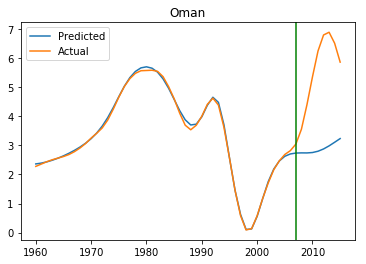

Doing Syrian Arab Republic


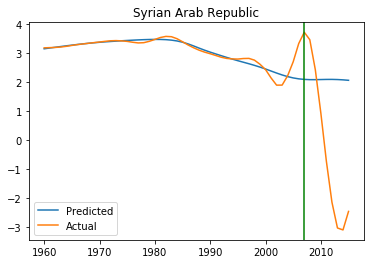

Doing Bahrain


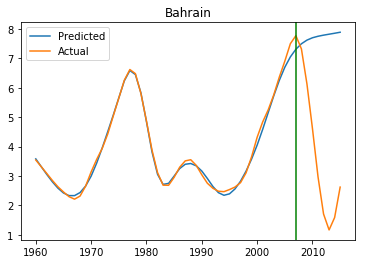

Doing Qatar


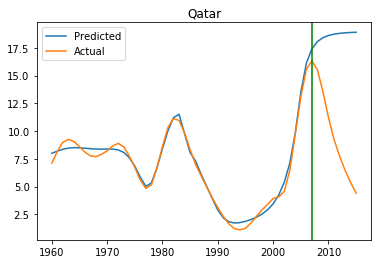

Doing United Arab Emirates


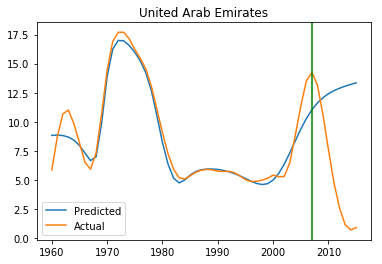

Doing Somalia


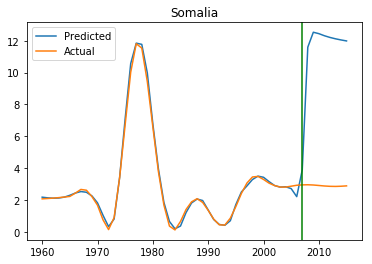

In [235]:
for i in range(-6,0):
    country = full_country_data[inds[i]]
    country_name = full_countries[inds[i]]
    all_x = country[:,:4]
    print("Doing", country_name)
    filename = "Models/" + country_name + "LSTM.ckpt"
    tf.reset_default_graph()
    model = LSTM(display_step=10000, learning_rate=.1)
    all_x = country[:,:4]
    train_x = country[:-1*num_test_years,:4]
    train_y = col(country[:-1*num_test_years, 4])
    test_x = country[-1*num_test_years:,:4]
    test_y = col(country[-1*num_test_years:,4])
    best_error = 1000
    for i in range(25):
        
        model.train(train_x, train_y, epochs=500, print_error=False)
        train_error = model.error(train_x, train_y)
        test_error = model.error(test_x, test_y)
#         print("Test error:", test_error)
        if test_error < best_error:
            best_error = test_error
            model.save(filename)
    #tf.set_random_seed(13)
    
    plt.plot(list(range(1960, 2016)), model.run(all_x))
    plt.plot(list(range(1960, 2016)), col(country[:,4]))
    plt.axvline(2016-num_test_years+1, color='g')
    plt.legend(["Predicted", "Actual"])
    plt.title(country_name)
    plt.show()
    

## Trying out training on all the examples

In [ ]:
tf.reset_default_graph()
#tf.set_random_seed(13)
model = LSTM(display_step=10000, learning_rate=.1)
filename = "/tmp/model.ckpt"
full_countries = [countries[i] for i in range(len(countries)) if len(country_data[i]) == 56]
full_country_data = [country for country in country_data if len(country) == 56]
num_test_years=10

for i in range(25):
    print("Loop number", i)
    for country in full_countries:
        all_x = country[:,:4]
        train_x = country[:-1*num_test_years,:4]
        train_y = col(country[:-1*num_test_years, 4])
        test_x = country[-1*num_test_years:,:4]
        test_y = col(country[-1*num_test_years:,4])
        best_error = 1000
        test_errors = []
        train_errors = []
        model.train(train_x, train_y, epochs=500, print_error=False)
        train_error = model.error(train_x, train_y)
        test_error = model.error(test_x, test_y)
        train_errors.append(train_error)
        test_errors.append(test_error)
        print("Test error:", test_error)
        if test_error < best_error:
            best_error = test_error
            model.save(filename)
            print("New best model! Model saved")
        plt.plot(list(range(1960, 2016)), model.run(all_x))
        plt.plot(list(range(1960, 2016)), col(country[:,4]))
        plt.axvline(2016-num_test_years+1, color='g')
        plt.legend(["Predicted", "Actual"])
        plt.show()

In [ ]:
#county = country_data[countries.index("Cuba")]
num_test_years = 5
train_x = county[:-1*num_test_years-1,:]
train_y = county[1:-1*num_test_years, :]
test_x = county[-1*num_test_years-1:-1,:]
test_y = county[-1*num_test_years:,:]
filename = "Models/firstmodel.ckpt"
best_error = 10**9
test_errors = []
train_errors = []
all_x = county[:-1, :]
date_range = list(frange(2014+8/12, 2018-2/12,1/12))
for i in range(50):
    print("Loop number", i+1)
    full_pred_LSTM.train(train_x, train_y, epochs=500, print_error=False)
    train_error = full_pred_LSTM.error(train_x, train_y)
    test_error = full_pred_LSTM.full_pred_error(all_x,num_test_years)
    train_errors.append(train_error)
    test_errors.append(test_error)
    print("Train error:", train_error)
    print("Test error:", test_error)
    if test_error < best_error:
        best_error = test_error
        full_pred_LSTM.save(filename)
        print("New best model! Model saved")
        plt.plot(date_range, np.vstack((full_pred_LSTM.run(all_x[:-1*num_test_years,:]),
                                                     full_pred_LSTM.predict_past(all_x[:-1*num_test_years,:], 
                                                                                 num_test_years)))[:,1])
        plt.plot(date_range, col(county[1:,1]))
        plt.axvline(2018-2/12-num_test_years+1, color='g')
        plt.legend(["Predicted", "Actual"])
        plt.show()
os.system('say "Finished."')

## Animation generation (future predict all features)

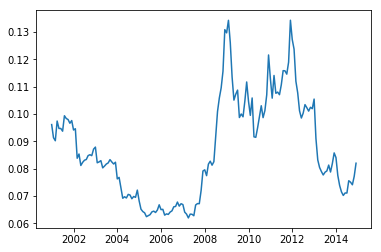

In [131]:
hai = county[1:,8] / county[1:,0]
date_range = list(frange(2001, 2015,1/12))
plt.plot(date_range, hai)

0 epochs
Training error: 3.28431
25 epochs
Training error: 3.26707
50 epochs
Training error: 3.24879
75 epochs
Training error: 3.22921
100 epochs
Training error: 3.20801
125 epochs
Training error: 3.18475
150 epochs
Training error: 3.15889
175 epochs
Training error: 3.12966
200 epochs
Training error: 3.09596
225 epochs
Training error: 3.05619
250 epochs
Training error: 3.00786
275 epochs
Training error: 2.94697
300 epochs
Training error: 2.86658
325 epochs
Training error: 2.75379
350 epochs
Training error: 2.58241
375 epochs
Training error: 2.29515
400 epochs
Training error: 1.78218
425 epochs
Training error: 1.13021
450 epochs
Training error: 0.891852
475 epochs
Training error: 0.852627
500 epochs
Training error: 0.83756
525 epochs
Training error: 0.825139
550 epochs
Training error: 0.812732
575 epochs
Training error: 0.799944
600 epochs
Training error: 0.786687
625 epochs
Training error: 0.772939
650 epochs
Training error: 0.758693
675 epochs
Training error: 0.743944
700 epochs
Train

0

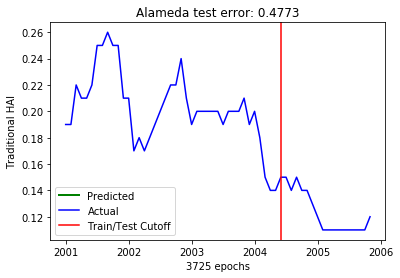

In [439]:
tf.reset_default_graph()
tf.set_random_seed(13)
num_test = 15
model = LSTM(num_outs=1, display_step=10000, learning_rate=.1, n_input=5, num_test_years = num_test)
filename = "/tmp/model.ckpt"
county_name = "Alameda"
num_test_years=20
hai = col(alamedaHAI[121:180])
data_points = np.array(county_data[0][132:191,:])
inds = [3,6,7,8,9]
features = data_points[:,inds]
train_x = features[:-1*num_test-1,:]
train_y = hai[1:-1*num_test]
test_x = features[-1*num_test-1:-1,:]
test_y = hai[-1*num_test:]
date_range = list(frange(2001, 2006-1/12,1/12))
num_epochs = 25
best_error = 1000
test_errors = []
train_errors = []
fig, ax = plt.subplots()
actual, = ax.plot(date_range, hai, color='blue')
vert = ax.axvline(2006-num_test_years/12+1/12, color='red')
line, = ax.plot([], [], lw=2, color='green')
ax.set_ylabel("Traditional HAI")
def init():
    line.set_data([], [])
    return (line,)
def update(i):
    label = '{0} epochs'.format(i * num_epochs)
    print(label)
    # ML stuff
    model.train(train_x, train_y, epochs=num_epochs)
    train_error = model.error(train_x, train_y)
    test_error = model.error(test_x, test_y)
    train_errors.append(train_error)
    test_errors.append(test_error)
    # Update the line and the axes (with a new xlabel). Return a tuple of
    # "artists" that have to be redrawn for this frame.
    line.set_xdata(date_range)
    pred_hai = model.run(features)
    line.set_ydata(pred_hai)
    ax.set_xlabel(label)
    
    ax.set_title(county_name + " test error: " + "{0:.4f}".format(test_error))
    ax.legend([line, actual, vert], ["Predicted", "Actual", "Train/Test Cutoff"])
    return line, ax


anim = FuncAnimation(fig, update, init_func = init, frames=150, interval=100)
anim.save(county_name + '.gif', dpi=80, writer='imagemagick')
os.system('say "The animation has finished saving."')

0 epochs
Training error: 1.46931
100 epochs
Training error: 1.43905
200 epochs
Training error: 1.40184
300 epochs
Training error: 1.35099
400 epochs
Training error: 1.26588
500 epochs
Training error: 1.09658
600 epochs
Training error: 0.97155
700 epochs
Training error: 0.89183
800 epochs
Training error: 0.828876
900 epochs
Training error: 0.77908
1000 epochs
Training error: 0.740205
1100 epochs
Training error: 0.707581
1200 epochs
Training error: 0.676528
1300 epochs
Training error: 0.644155
1400 epochs
Training error: 0.608778
1500 epochs
Training error: 0.569512
1600 epochs
Training error: 0.526474
1700 epochs
Training error: 0.486943
1800 epochs
Training error: 0.450914
1900 epochs
Training error: 0.420508
2000 epochs
Training error: 0.395095
2100 epochs
Training error: 0.373784
2200 epochs
Training error: 0.355798
2300 epochs
Training error: 0.340474
2400 epochs
Training error: 0.327288
2500 epochs
Training error: 0.315835
2600 epochs
Training error: 0.305806
2700 epochs
Training e

0

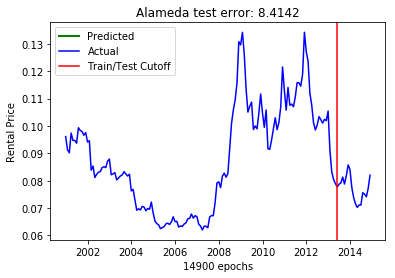

In [367]:
tf.reset_default_graph()
tf.set_random_seed(13)
model = LSTM(num_outs=10, display_step=10000, learning_rate=.1, n_input=10, num_test_years = 20)
filename = "/tmp/model.ckpt"
county_name = "Alameda"
num_test_years=20
date_range = list(frange(2001, 2015,1/12))
num_epochs = 100
dat = county_data[counties.index("Alameda")]
county = dat[132:301,:]
all_x = county[:-1, :]
train_x = county[:-1*num_test_years-1,:]
train_y = county[1:-1*num_test_years, :]
test_x = county[-1*num_test_years-1:-1,:]
test_y = county[-1*num_test_years:,:]
best_error = 1000
test_errors = []
train_errors = []
fig, ax = plt.subplots()
actual, = ax.plot(date_range, county[1:,8] / county[1:,0], color='blue')
vert = ax.axvline(2015-num_test_years/12+1/12, color='red')
line, = ax.plot([], [], lw=2, color='green')
ax.set_ylabel("Rental Price")
def init():
    line.set_data([], [])
    return (line,)
def update(i):
    label = '{0} epochs'.format(i * num_epochs)
    print(label)
    # ML stuff
    model.train(train_x, train_y, epochs=num_epochs)
    train_error = model.error(train_x, train_y)
    test_error = model.error(test_x, test_y)
    train_errors.append(train_error)
    test_errors.append(test_error)
    # Update the line and the axes (with a new xlabel). Return a tuple of
    # "artists" that have to be redrawn for this frame.
    line.set_xdata(date_range)
    result = np.vstack((model.run(all_x[:-1*num_test,:]), 
                            model.predict_past(all_x[:-1*num_test,:],num_test)))
    line.set_ydata(result[:,8]/result[:,0])
    ax.set_xlabel(label)
    
    ax.set_title(county_name + " test error: " + "{0:.4f}".format(test_error))
    ax.legend([line, actual, vert], ["Predicted", "Actual", "Train/Test Cutoff"])
    return line, ax


anim = FuncAnimation(fig, update, init_func = init, frames=150, interval=100)
anim.save(county_name + '.gif', dpi=80, writer='imagemagick')
os.system('say "The animation has finished saving."')

In [206]:
model.x_scaler.scale_

array([ 0.,  0.,  0.,  0.], dtype=float32)

In [198]:
HTML(anim.to_html5_video())

1

## Making the 25 plot plots

0 epochs
0 epochs
100 epochs
200 epochs
300 epochs
400 epochs
500 epochs
600 epochs
700 epochs
800 epochs
900 epochs
1000 epochs
1100 epochs
1200 epochs
1300 epochs
1400 epochs
1500 epochs
1600 epochs
1700 epochs
1800 epochs
1900 epochs
2000 epochs
2100 epochs
2200 epochs
2300 epochs
2400 epochs
2500 epochs
2600 epochs
2700 epochs
2800 epochs
2900 epochs
3000 epochs
3100 epochs
3200 epochs
3300 epochs
3400 epochs
3500 epochs
3600 epochs
3700 epochs
3800 epochs
3900 epochs
4000 epochs
4100 epochs
4200 epochs
4300 epochs
4400 epochs
4500 epochs
4600 epochs
4700 epochs
4800 epochs
4900 epochs
5000 epochs
5100 epochs
5200 epochs
5300 epochs
5400 epochs
5500 epochs
5600 epochs
5700 epochs
5800 epochs
5900 epochs
6000 epochs
6100 epochs
6200 epochs
6300 epochs
6400 epochs
6500 epochs
6600 epochs
6700 epochs
6800 epochs
6900 epochs
7000 epochs
7100 epochs
7200 epochs
7300 epochs
7400 epochs
7500 epochs
7600 epochs
7700 epochs
7800 epochs
7900 epochs
8000 epochs
8100 epochs
8200 epochs
8300 ep

0

0 epochs


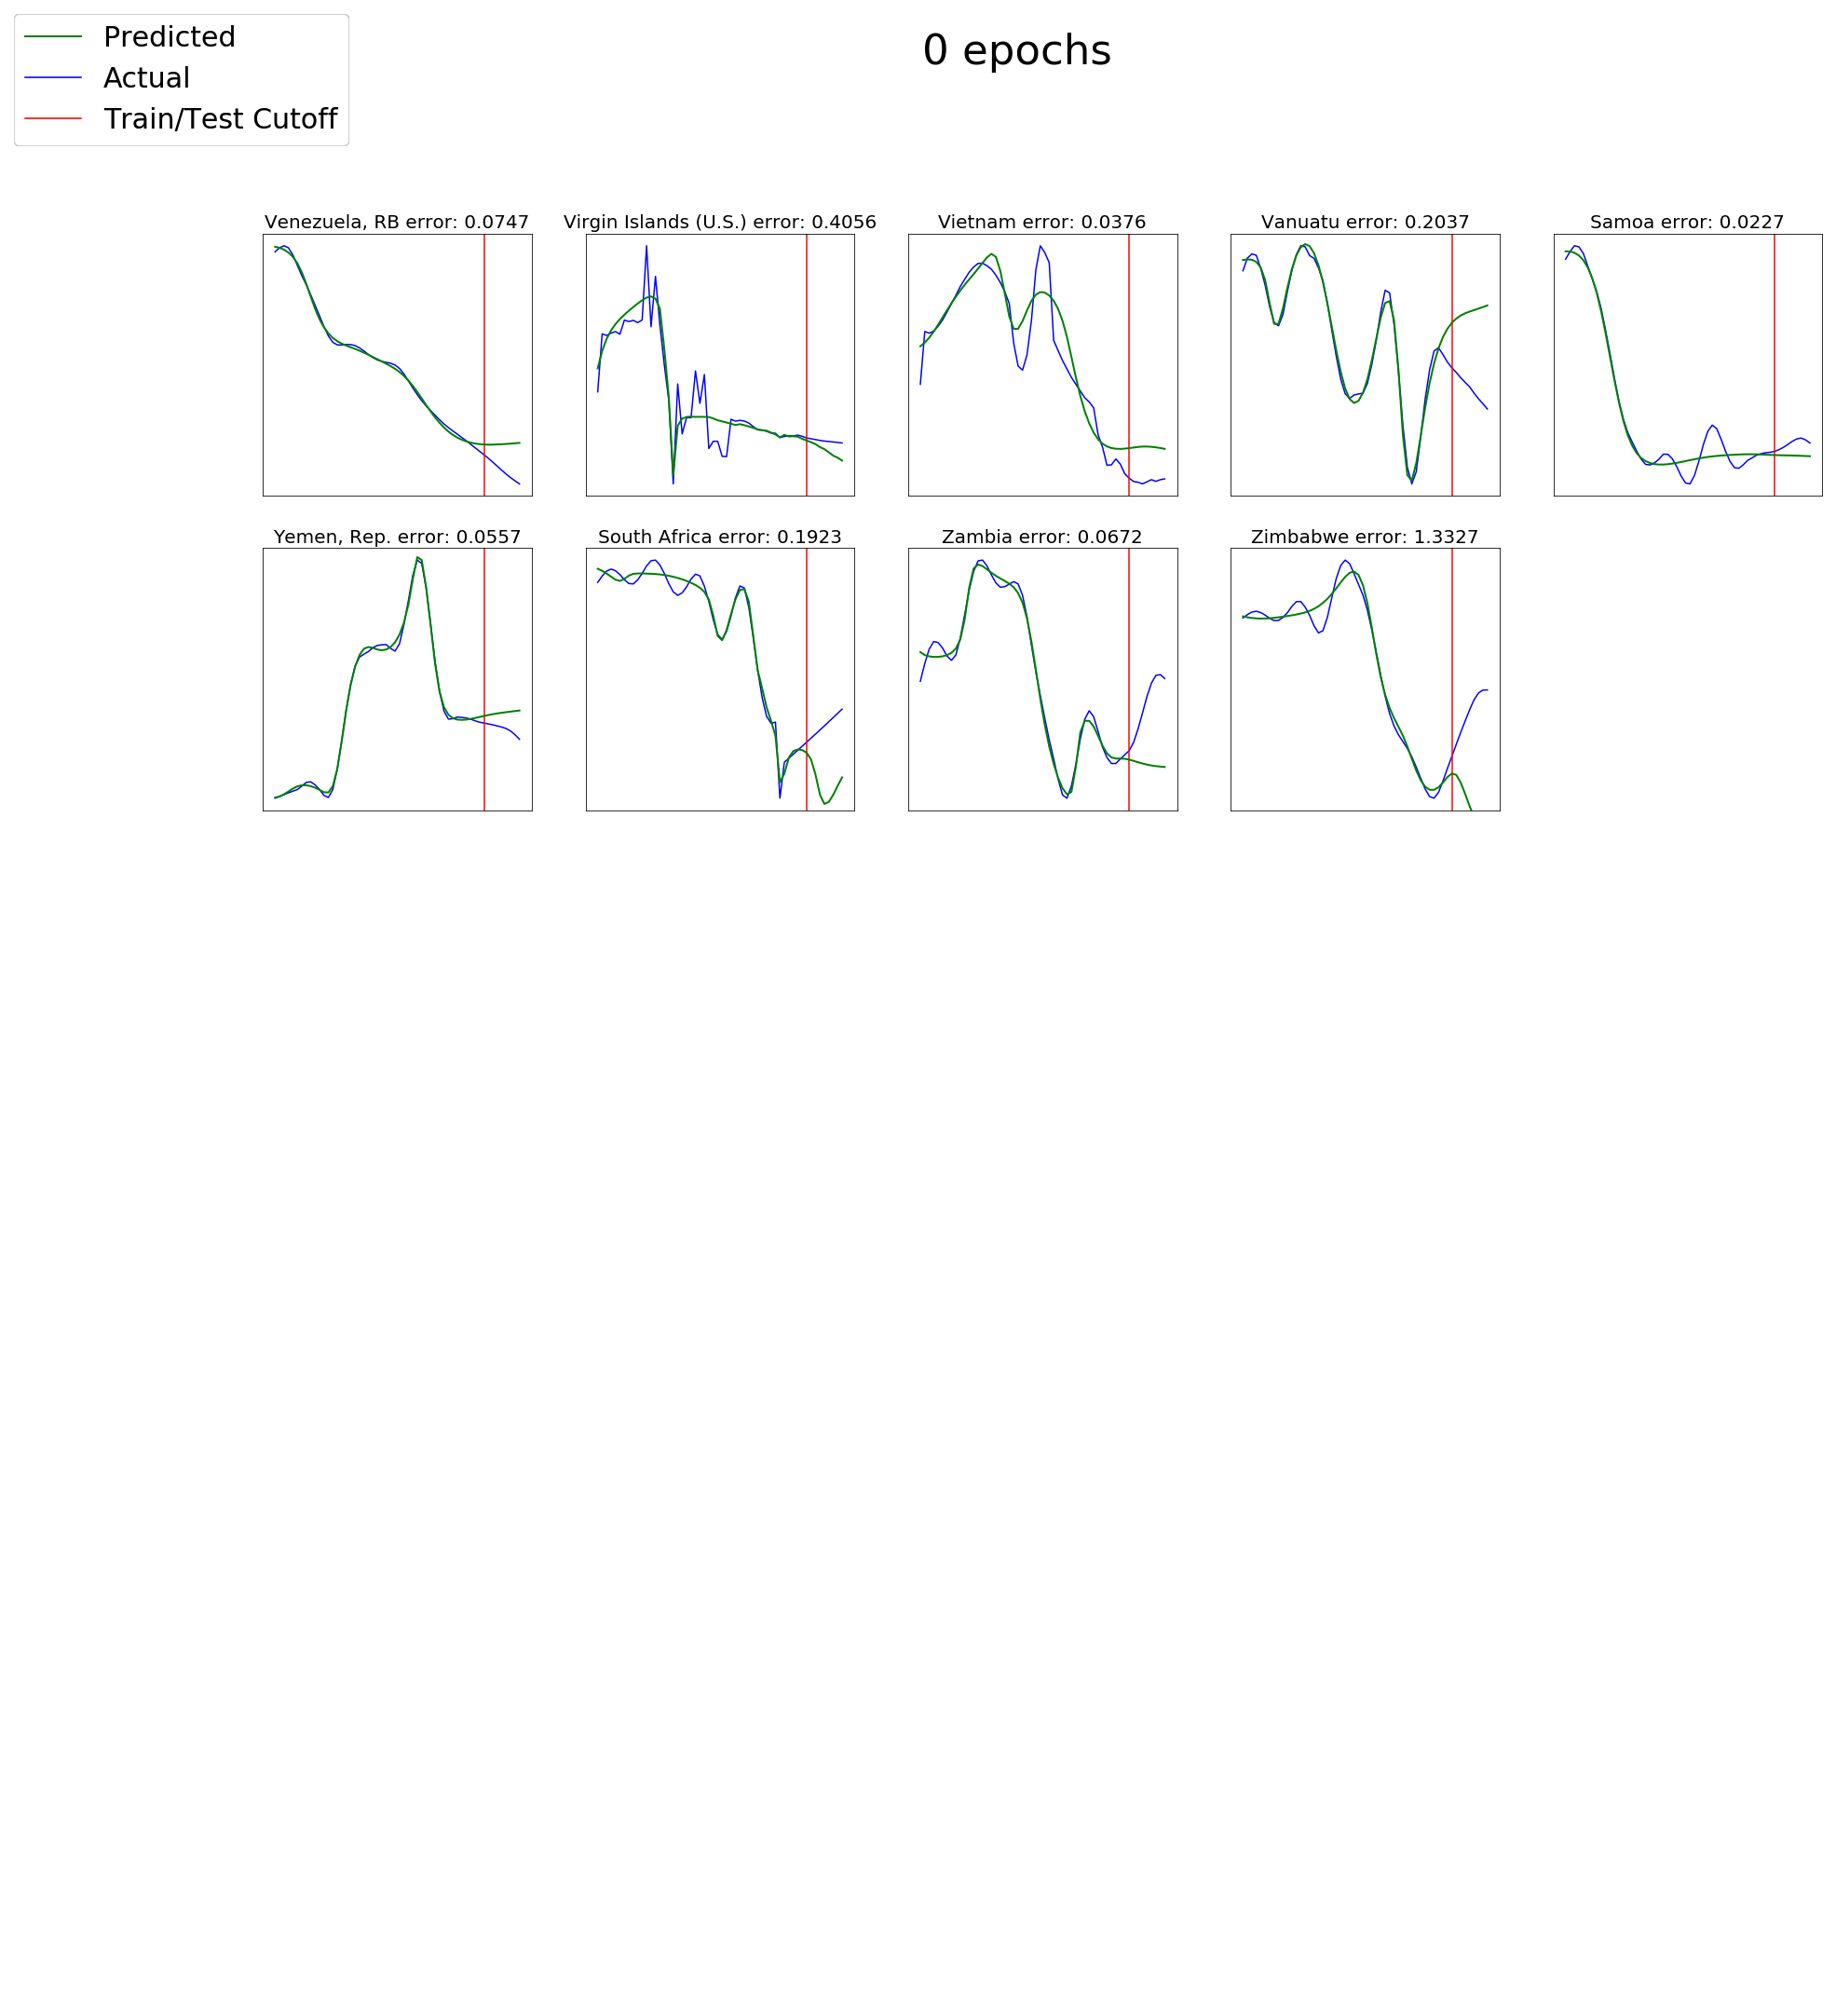

In [196]:
def coords_to_ind(x,y):
    return x+5*y
def ind_to_coords(i):
    y = i // 5
    x = i - y * 5
    return x,y
tf.reset_default_graph()
tf.set_random_seed(13)
filename = "/tmp/model.ckpt"
num_test_years=10
num_epochs = 100
years = list(range(1960, 2016))
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(30,30))
full_countries = [countries[i] for i in range(len(countries)) if len(country_data[i]) == 56]
full_country_data = [country for country in country_data if len(country) == 56]

# Select number of countries here
start_ind = 175
end_ind = 184
full_country_data = full_country_data[start_ind:end_ind]
full_countries = full_countries[start_ind:end_ind]

models = []
train_xs = []
train_ys = []
test_xs = []
test_ys = []
all_xs = []
actuals = []
verts = []
lines = []
for i in range(len(full_country_data)):
    country = full_country_data[i]
    x,y = ind_to_coords(i)
    with tf.variable_scope(str(i)):
        models.append(LSTM(display_step=10000, learning_rate=.1))
    train_xs.append(country[:-1*num_test_years,:4])
    train_ys.append(col(country[:-1*num_test_years, 4]))
    test_xs.append(country[-1*num_test_years:,:4])
    test_ys.append(col(country[-1*num_test_years:,4]))
    all_xs.append(country[:,:4])
    actual, = ax[y,x].plot(years, col(country[:,4]), color='blue')
    vert = ax[y,x].axvline(2016-num_test_years+1, color='red')
    actuals.append(actual)
    verts.append(vert)
    line, = ax[y,x].plot([], [], lw=2, color='green')
    lines.append(line)
    ax[y,x].get_xaxis().set_visible(False)
    ax[y,x].get_yaxis().set_visible(False)
    #ax[y,x].set_ylabel("Population rate")
if end_ind - start_ind < 25:
    for i in range(end_ind, start_ind + 25): 
        x,y = ind_to_coords(i-start_ind)
        ax[y,x].axis('off')
os.system('say "Finished initializing."')
def init():
    line.set_data([], [])
    return (line,)
def update(i):
    label = '{0} epochs'.format(i * num_epochs)
    print(label)
    # ML stuff
    for i in range(len(full_country_data)):
        models[i].train(train_xs[i], train_ys[i], epochs=num_epochs, print_error=False)
        test_error = models[i].error(test_xs[i], test_ys[i])
        x,y = ind_to_coords(i)
        ax[y,x].set_title(full_countries[i] + " error: " + "{0:.4f}".format(test_error[0]),size=20)
#         ax[y,x].get_xaxis().set_visible(False)
#         ax[y,x].get_yaxis().set_visible(False)
        lines[i].set_xdata(years)
        lines[i].set_ydata(models[i].run(all_xs[i]))
    fig.legend([lines[0], actuals[0], verts[0]], ["Predicted", "Actual", "Train/Test Cutoff"],
               loc='upper left', fontsize=30)
    fig.suptitle(label,size=45)
    return line, ax


anim = FuncAnimation(fig, update, frames=100, interval=100)
anim.save('seventh.gif', dpi=80, writer='imagemagick')
os.system('say "The animation has finished saving."')

## Training one model on all examples

0 epochs
0 epochs
100 epochs
200 epochs
300 epochs
400 epochs
500 epochs
600 epochs
700 epochs
800 epochs
900 epochs
1000 epochs
1100 epochs
1200 epochs
1300 epochs
1400 epochs
1500 epochs
1600 epochs
1700 epochs
1800 epochs
1900 epochs
2000 epochs
2100 epochs
2200 epochs
2300 epochs
2400 epochs
2500 epochs
2600 epochs
2700 epochs
2800 epochs
2900 epochs
3000 epochs
3100 epochs
3200 epochs
3300 epochs
3400 epochs
3500 epochs
3600 epochs
3700 epochs
3800 epochs
3900 epochs
4000 epochs
4100 epochs
4200 epochs
4300 epochs
4400 epochs
4500 epochs
4600 epochs
4700 epochs
4800 epochs
4900 epochs
5000 epochs
5100 epochs
5200 epochs
5300 epochs
5400 epochs
5500 epochs
5600 epochs
5700 epochs
5800 epochs
5900 epochs
6000 epochs
6100 epochs
6200 epochs
6300 epochs
6400 epochs
6500 epochs
6600 epochs
6700 epochs
6800 epochs
6900 epochs
7000 epochs
7100 epochs
7200 epochs
7300 epochs
7400 epochs
7500 epochs
7600 epochs
7700 epochs
7800 epochs
7900 epochs
8000 epochs
8100 epochs
8200 epochs
8300 ep

0

0 epochs


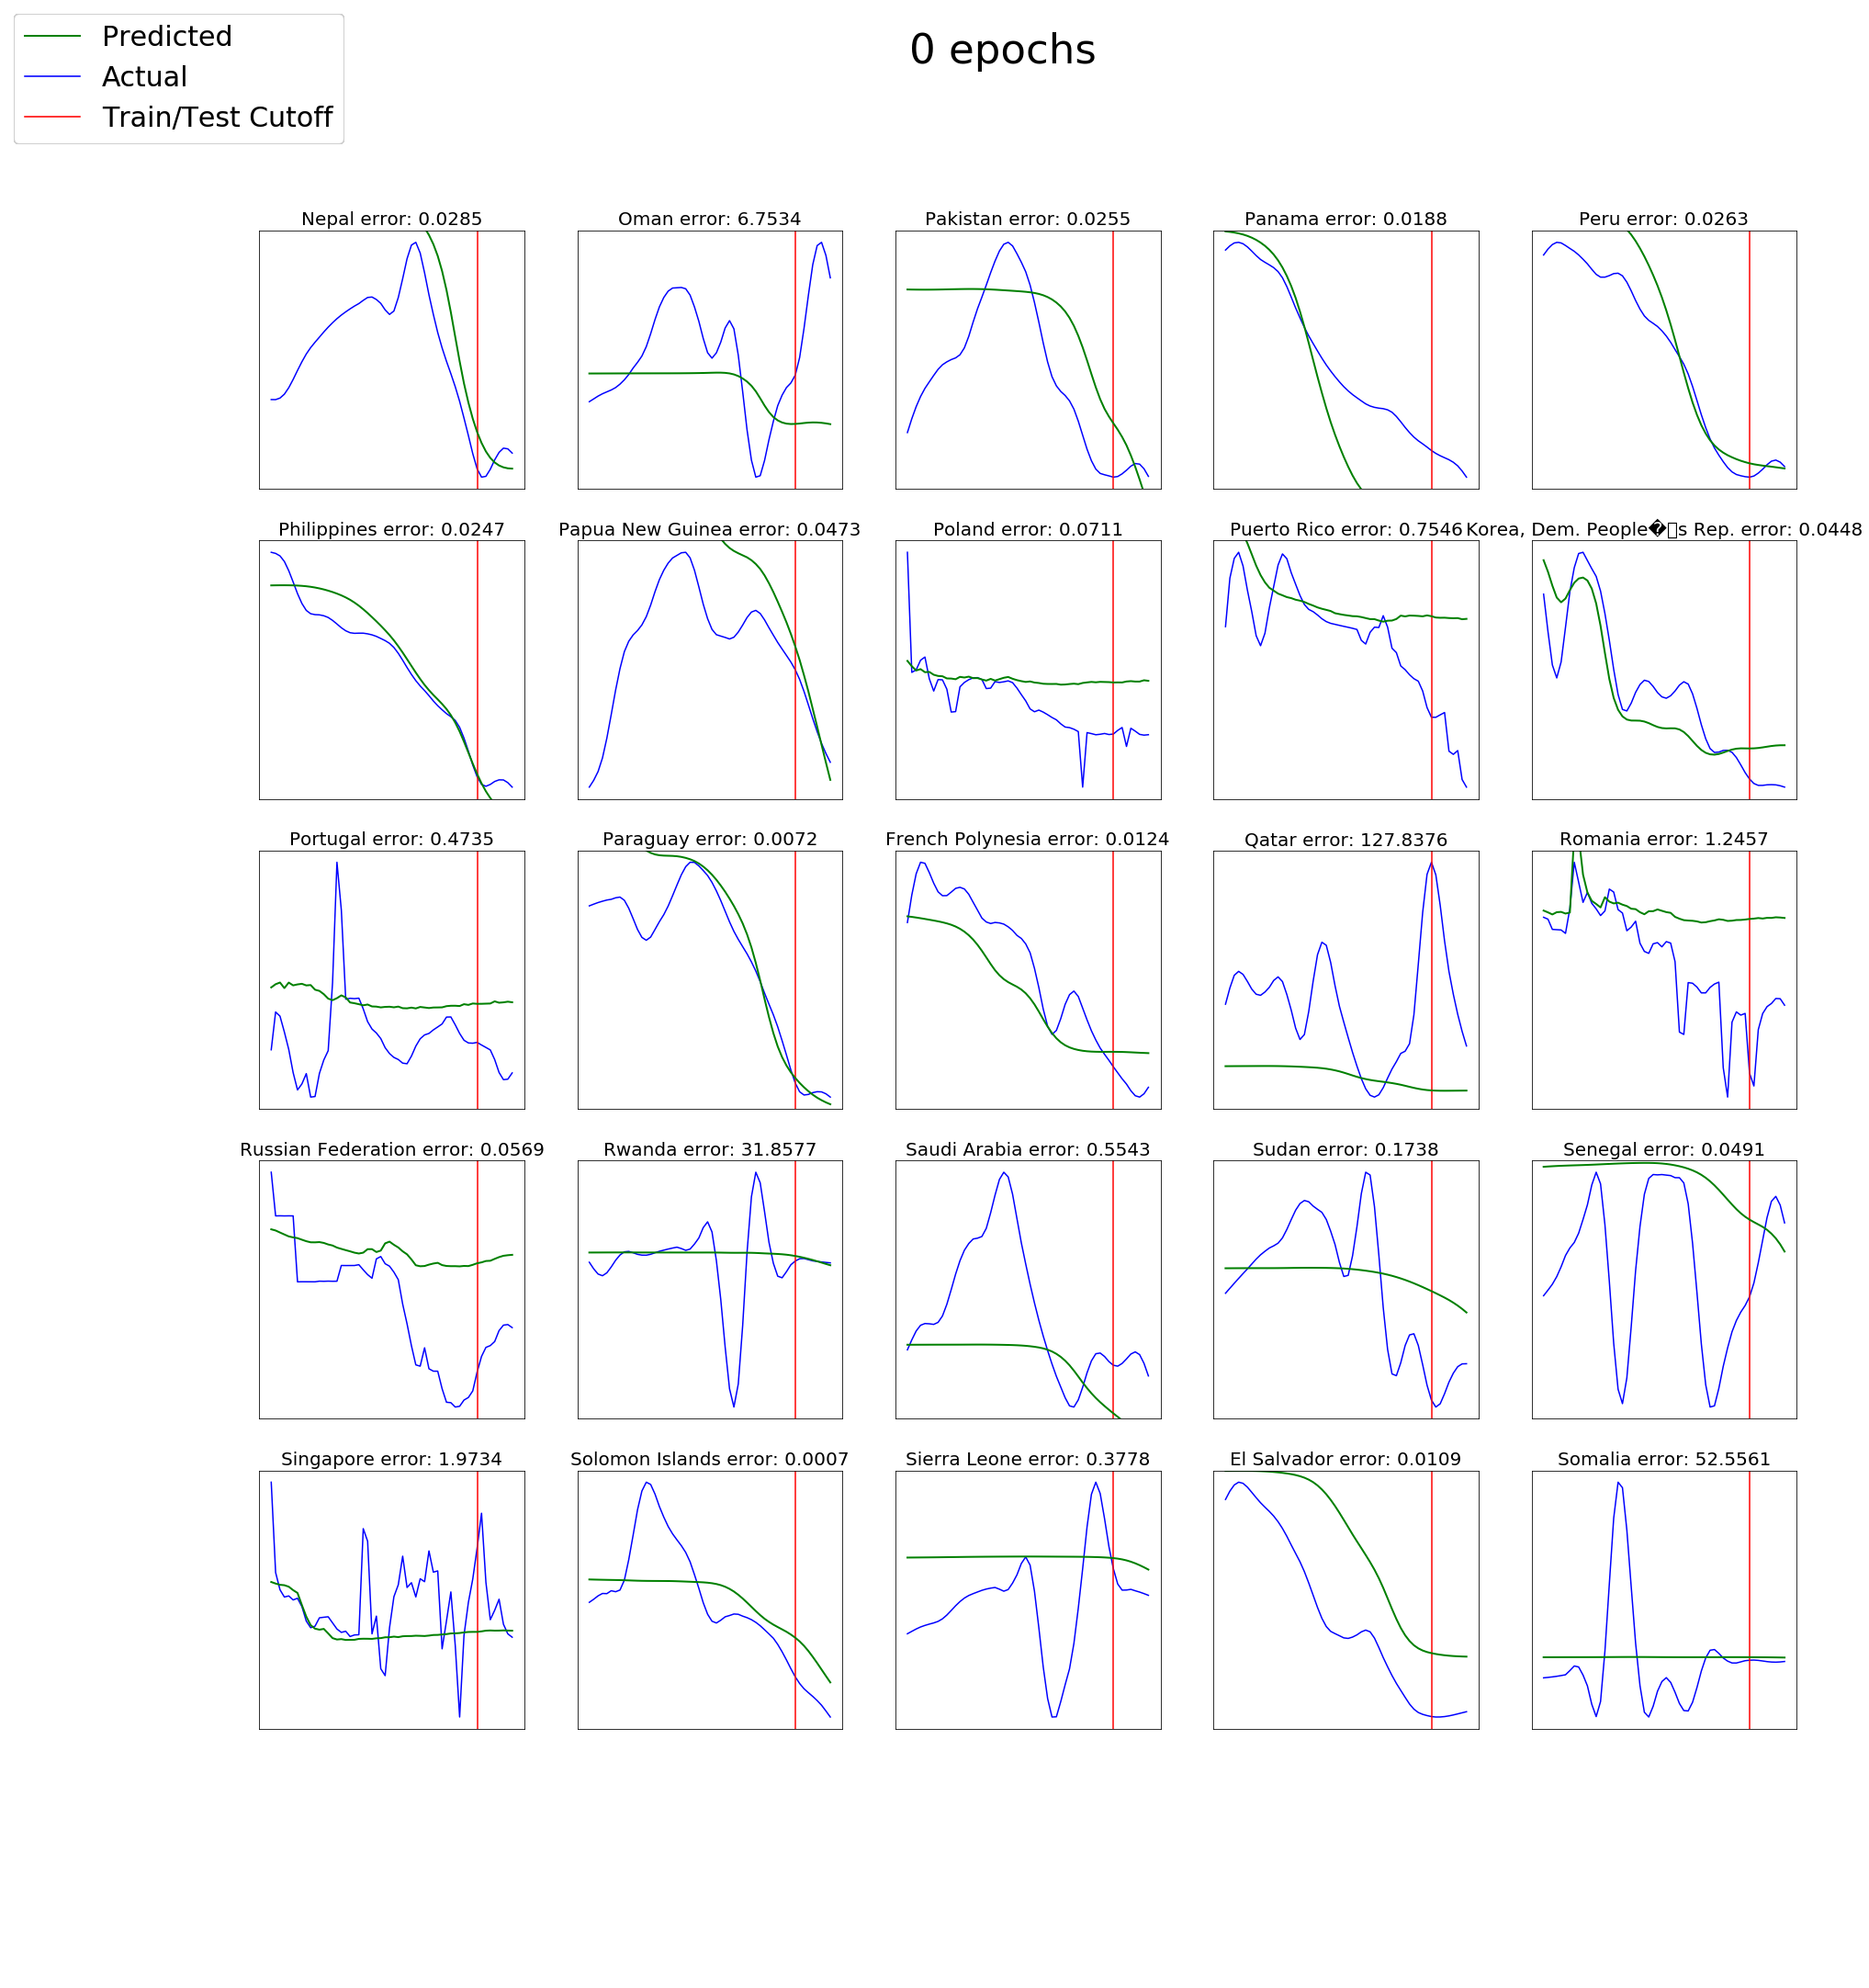

In [192]:
def coords_to_ind(x,y):
    return x+5*y
def ind_to_coords(i):
    y = i // 5
    x = i - y * 5
    return x,y
tf.reset_default_graph()
tf.set_random_seed(13)
model = LSTM(display_step=10000, learning_rate=.1)
filename = "/tmp/model.ckpt"
num_test_years=10
num_epochs = 100
years = list(range(1960, 2016))
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(30,30))
full_countries = [countries[i] for i in range(len(countries)) if len(country_data[i]) == 56]
full_country_data = [country for country in country_data if len(country) == 56]

# Select number of countries here
start_ind = 125
end_ind = 150
full_country_data = full_country_data[start_ind:end_ind]
full_countries = full_countries[start_ind:end_ind]

train_xs = []
train_ys = []
test_xs = []
test_ys = []
all_xs = []
actuals = []
verts = []
lines = []

for i in range(len(full_country_data)):
    country = full_country_data[i]
    x,y = ind_to_coords(i)
    train_xs.append(country[:-1*num_test_years,:4])
    train_ys.append(col(country[:-1*num_test_years, 4]))
    test_xs.append(country[-1*num_test_years:,:4])
    test_ys.append(col(country[-1*num_test_years:,4]))
    all_xs.append(country[:,:4])
    actual, = ax[y,x].plot(years, col(country[:,4]), color='blue')
    vert = ax[y,x].axvline(2016-num_test_years+1, color='red')
    actuals.append(actual)
    verts.append(vert)
    line, = ax[y,x].plot([], [], lw=2, color='green')
    lines.append(line)
    ax[y,x].set_ylabel("Population rate")
os.system('say "Finished initializing."')
def init():
    line.set_data([], [])
    return (line,)
def update(i):
    label = '{0} epochs'.format(i * num_epochs)
    print(label)
    # ML stuff
    for _ in range(num_epochs):
        for i in range(len(full_country_data)):
            model.train(train_xs[i], train_ys[i], epochs=1, print_error=False)
    for i in range(len(full_country_data)):
        test_error = models[i].error(test_xs[i], test_ys[i])
        x,y = ind_to_coords(i)
        ax[y,x].set_title(full_countries[i] + " error: " + "{0:.4f}".format(test_error[0]),size=20)
        ax[y,x].get_xaxis().set_visible(False)
        ax[y,x].get_yaxis().set_visible(False)
        lines[i].set_xdata(years)
        lines[i].set_ydata(model.run(all_xs[i]))
    fig.legend([lines[0], actuals[0], verts[0]], ["Predicted", "Actual", "Train/Test Cutoff"],
               loc='upper left', fontsize=30)
    fig.suptitle(label,size=45)
    return line, ax


anim = FuncAnimation(fig, update, frames=100, interval=100)
anim.save('all.gif', dpi=80, writer='imagemagick')
os.system('say "The animation has finished saving."')

## Code for making gifs for each country

Aruba finished.
Afghanistan finished.
Angola finished.
Albania finished.
United Arab Emirates finished.
Argentina finished.
Armenia finished.
Antigua and Barbuda finished.
Australia finished.
Austria finished.
Azerbaijan finished.
Burundi finished.
Belgium finished.
Benin finished.
Burkina Faso finished.
Bangladesh finished.
Bulgaria finished.
Bahrain finished.
Bahamas, The finished.
Bosnia and Herzegovina finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Belarus finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Belize finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Bolivia finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Brazil finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Barbados finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Brunei Darussalam finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Bhutan finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Botswana finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Central African Republic finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Canada finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Switzerland finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Channel Islands finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Chile finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


China finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Cote d'Ivoire finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Cameroon finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Congo, Dem. Rep. finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Congo, Rep. finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Colombia finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Comoros finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Cabo Verde finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Costa Rica finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Cuba finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Cyprus finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Czech Republic finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Germany finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Djibouti finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Denmark finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Dominican Republic finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Algeria finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Ecuador finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Egypt, Arab Rep. finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Spain finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Estonia finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Ethiopia finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Finland finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Fiji finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


France finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Micronesia, Fed. Sts. finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Gabon finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


United Kingdom finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Georgia finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Ghana finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Guinea finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Gambia, The finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Guinea-Bissau finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Equatorial Guinea finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Greece finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Grenada finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Guatemala finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Guam finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Guyana finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Hong Kong SAR, China finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Honduras finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Haiti finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Hungary finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Indonesia finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


India finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Ireland finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Iran, Islamic Rep. finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Iraq finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Iceland finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Italy finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Jamaica finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Jordan finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Japan finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Kazakhstan finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Kenya finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Kyrgyz Republic finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Cambodia finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Kiribati finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Korea, Rep. finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Lao PDR finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Lebanon finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Liberia finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Libya finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


St. Lucia finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Sri Lanka finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Lesotho finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Lithuania finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Latvia finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Macao SAR, China finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Morocco finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Moldova finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Madagascar finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Maldives finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Mexico finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Macedonia, FYR finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Mali finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Malta finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Myanmar finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Montenegro finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Mongolia finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Mozambique finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Mauritania finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Mauritius finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Malawi finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Malaysia finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Namibia finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


New Caledonia finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Niger finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Nigeria finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Nicaragua finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Netherlands finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Norway finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Nepal finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Oman finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Pakistan finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Panama finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Peru finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Philippines finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Papua New Guinea finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Poland finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Puerto Rico finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Korea, Dem. People�۪s Rep. finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Portugal finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Paraguay finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


French Polynesia finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Qatar finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Romania finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Russian Federation finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Rwanda finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Saudi Arabia finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Sudan finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Senegal finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Singapore finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Solomon Islands finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Sierra Leone finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


El Salvador finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Somalia finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


South Sudan finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Sao Tome and Principe finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Suriname finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Slovak Republic finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Slovenia finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Sweden finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Swaziland finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Syrian Arab Republic finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Chad finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Togo finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Thailand finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Tajikistan finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Turkmenistan finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Timor-Leste finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Tonga finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Trinidad and Tobago finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Tunisia finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Turkey finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Tanzania finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Uganda finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Ukraine finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Uruguay finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


United States finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Uzbekistan finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


St. Vincent and the Grenadines finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Venezuela, RB finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Virgin Islands (U.S.) finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Vietnam finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Vanuatu finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Samoa finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Yemen, Rep. finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


South Africa finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Zambia finished.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Zimbabwe finished.


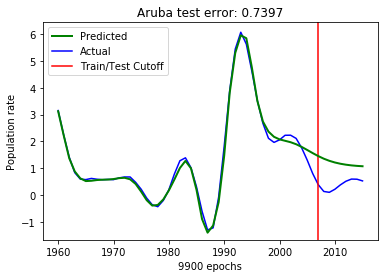

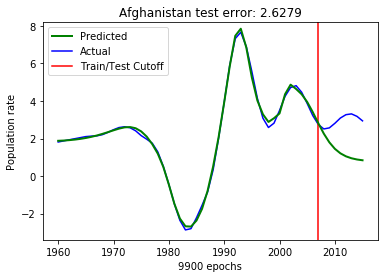

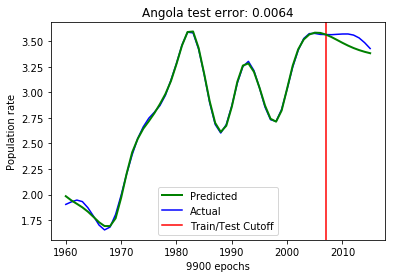

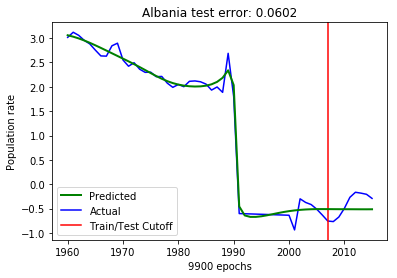

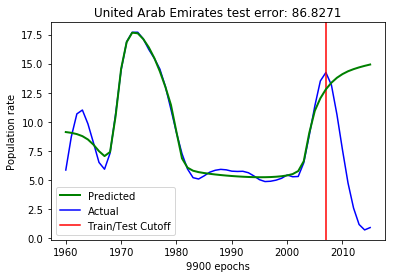

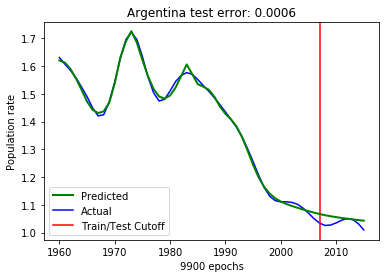

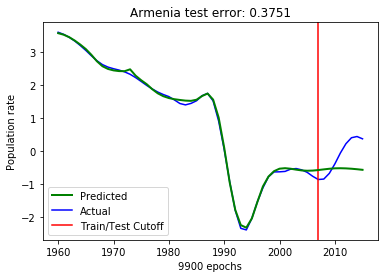

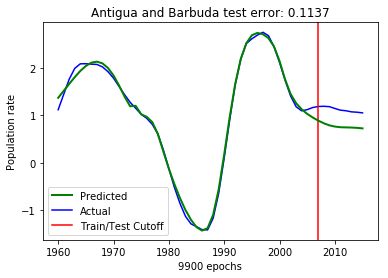

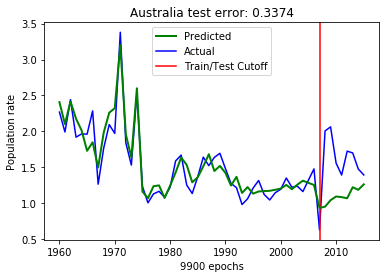

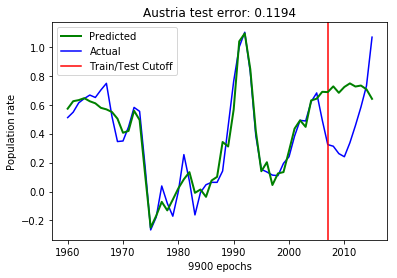

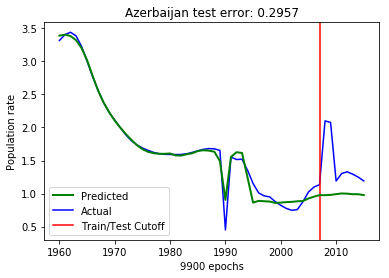

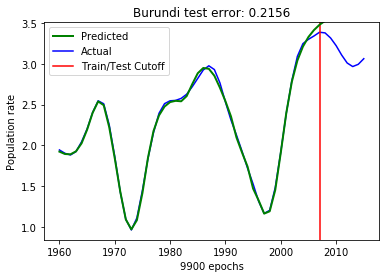

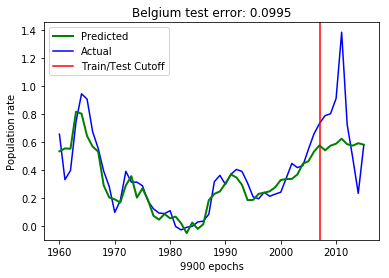

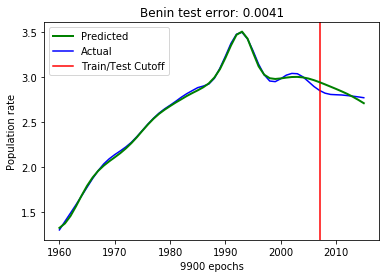

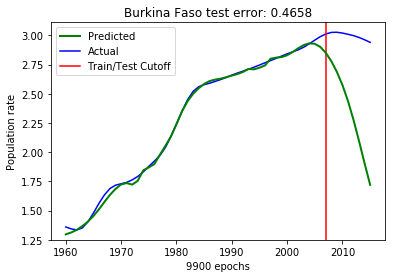

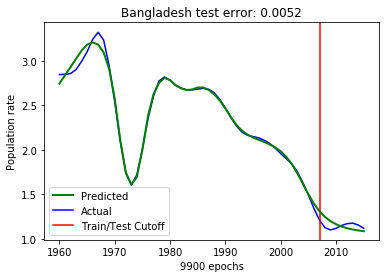

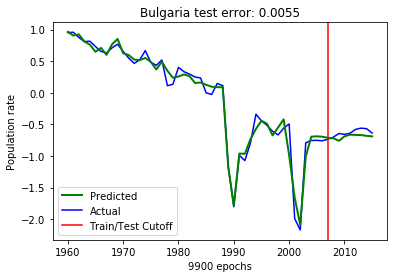

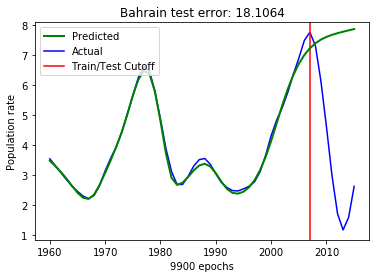

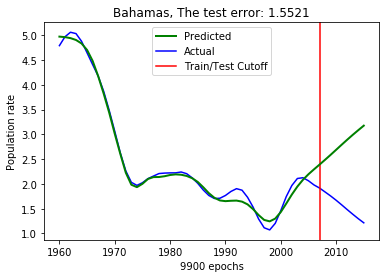

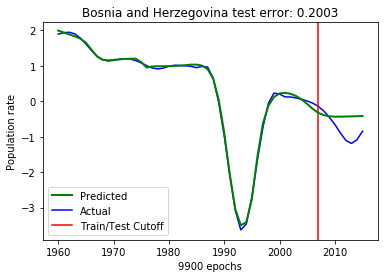

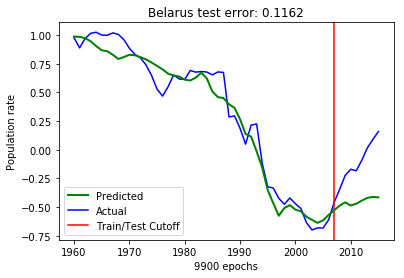

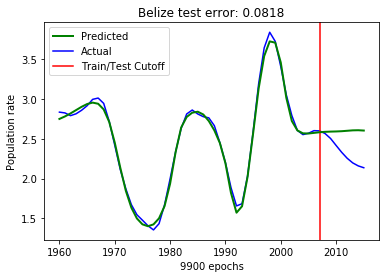

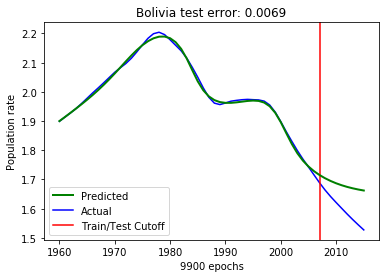

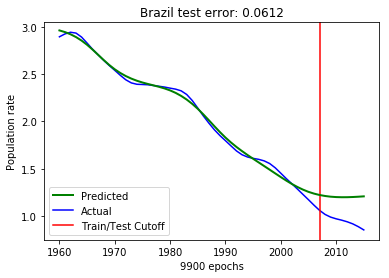

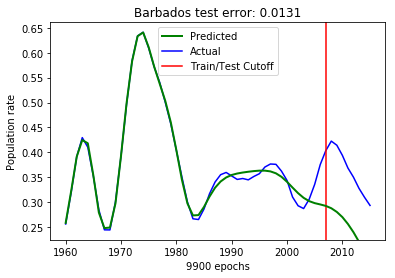

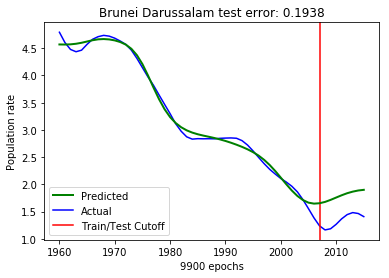

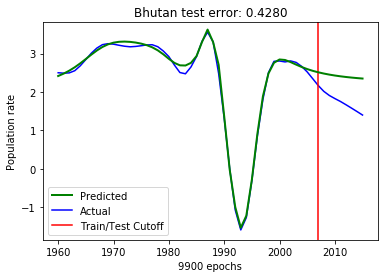

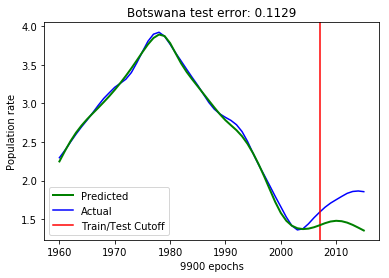

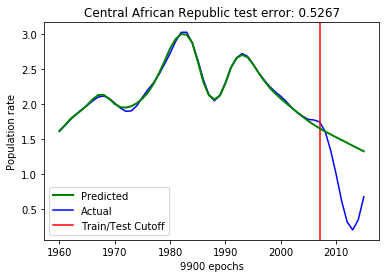

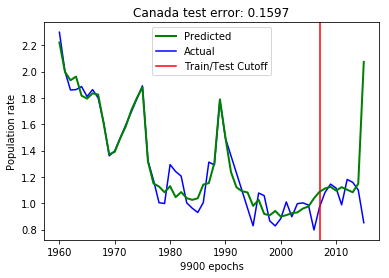

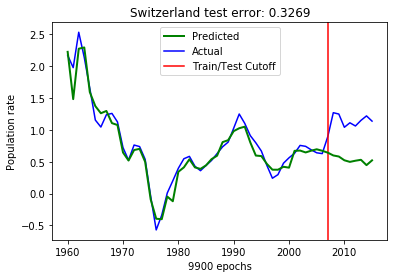

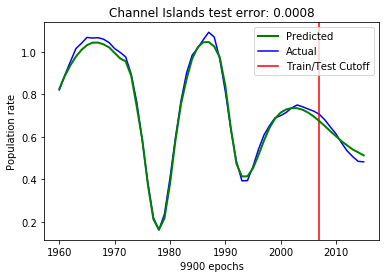

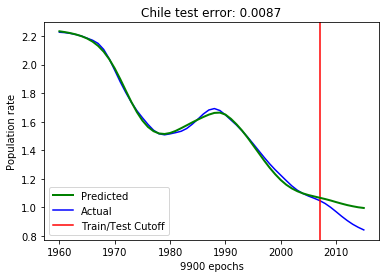

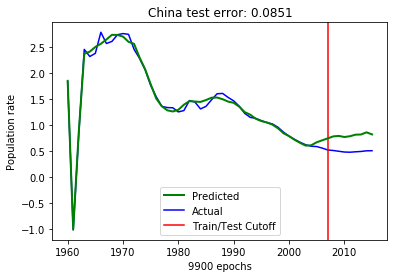

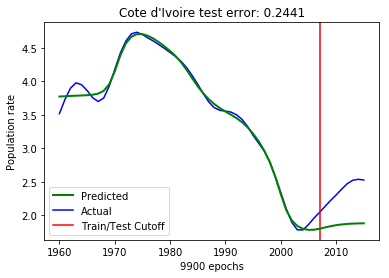

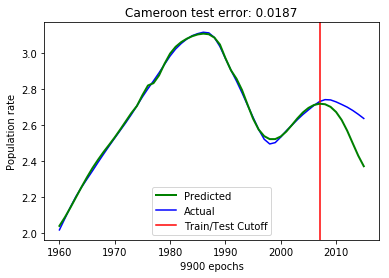

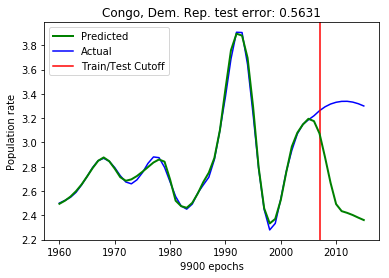

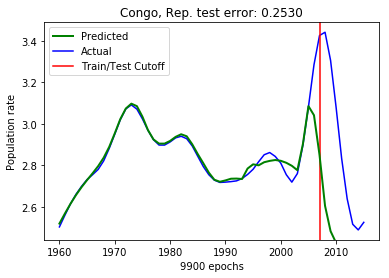

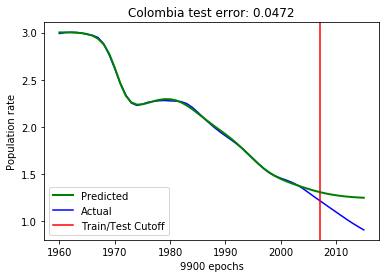

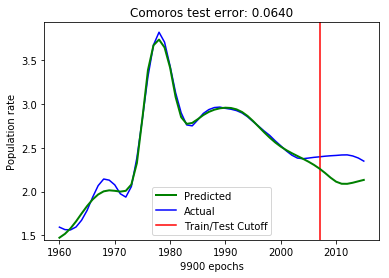

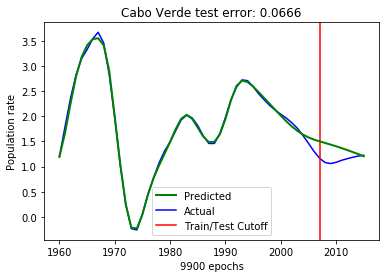

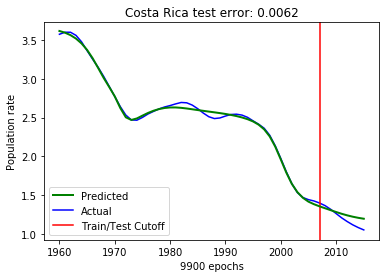

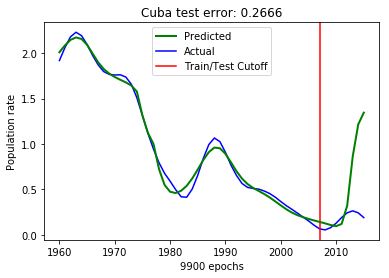

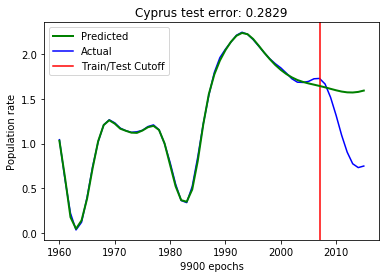

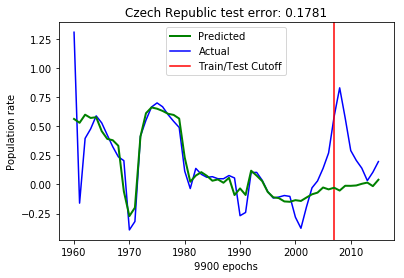

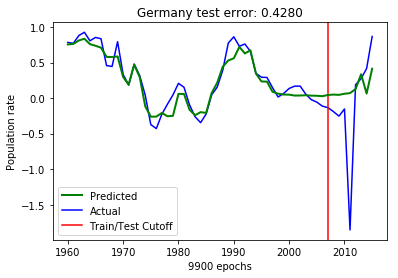

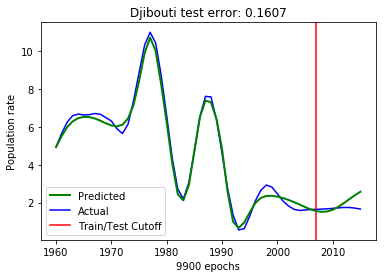

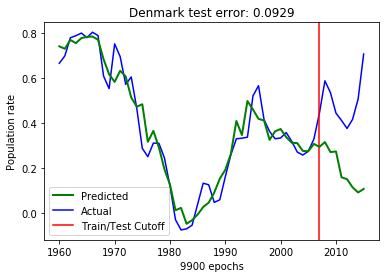

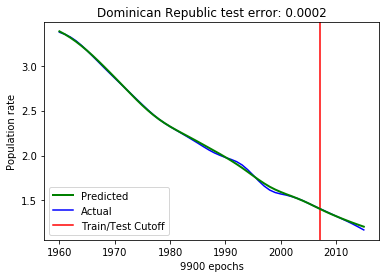

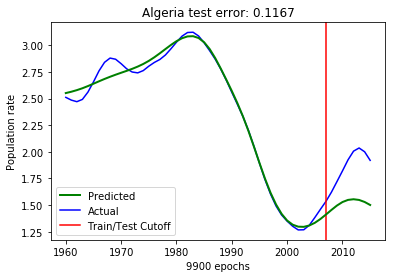

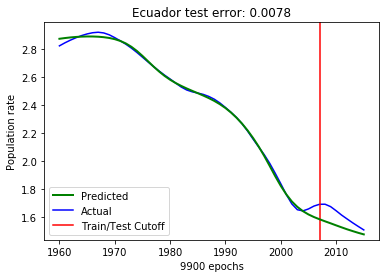

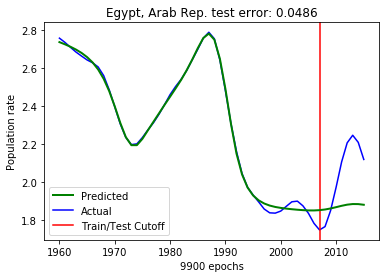

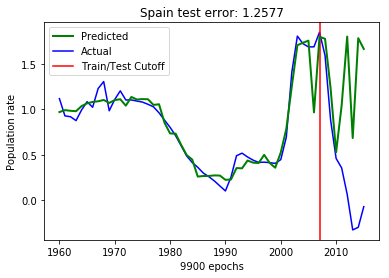

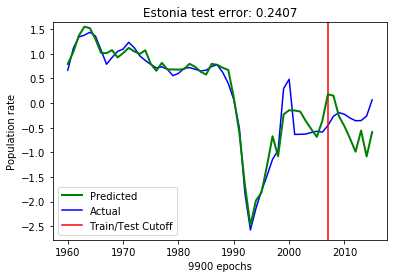

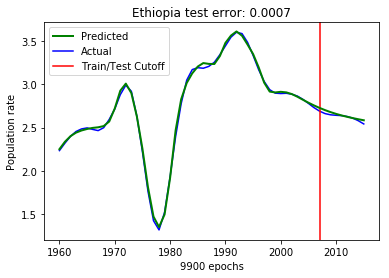

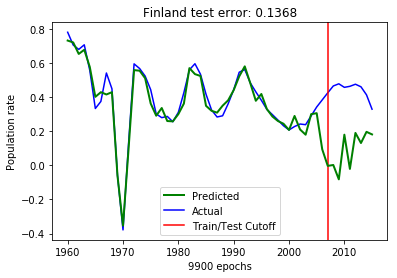

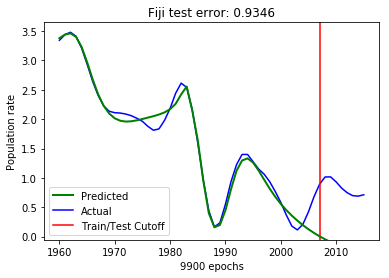

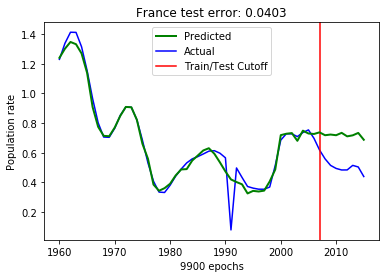

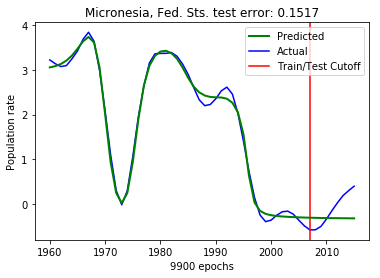

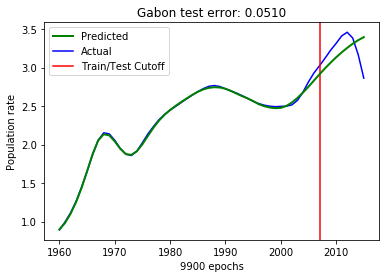

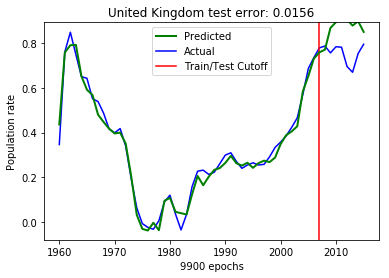

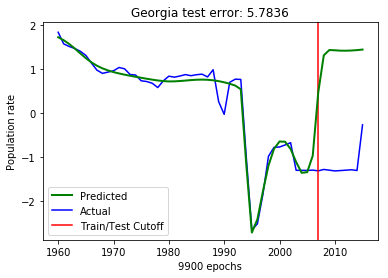

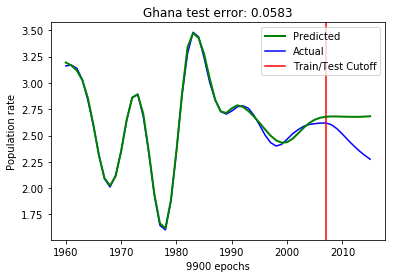

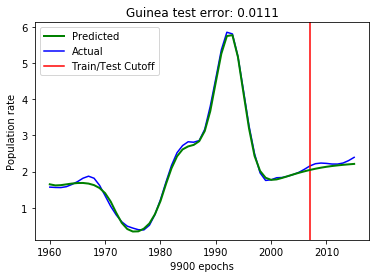

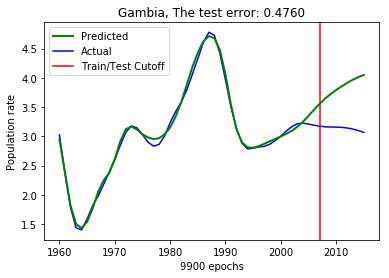

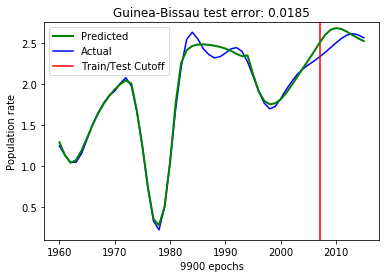

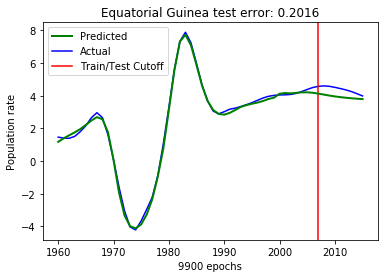

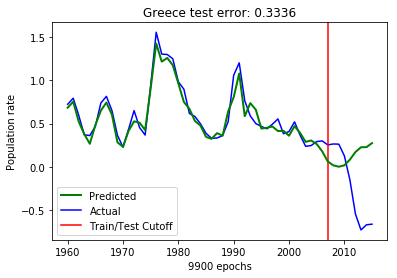

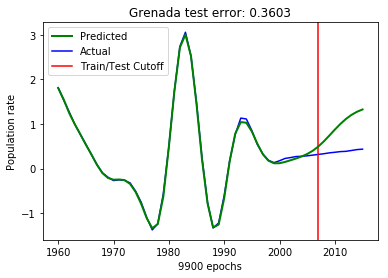

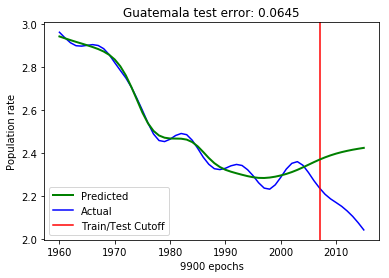

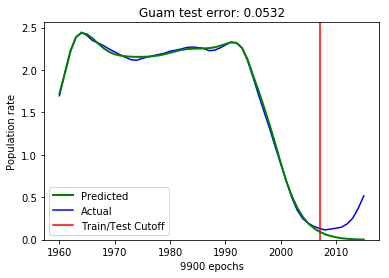

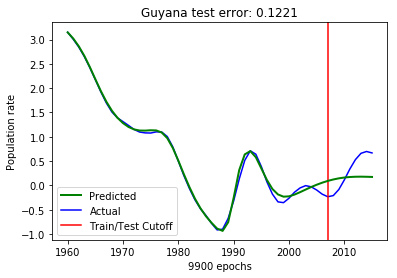

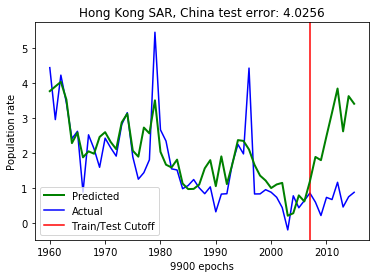

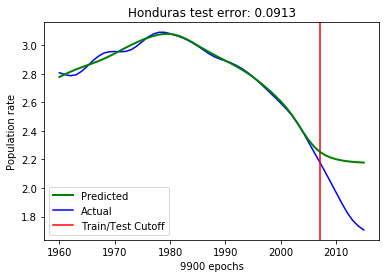

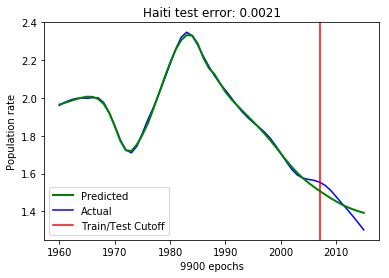

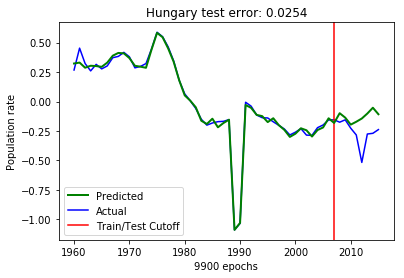

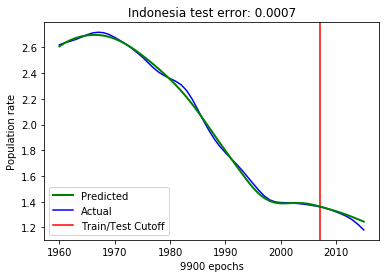

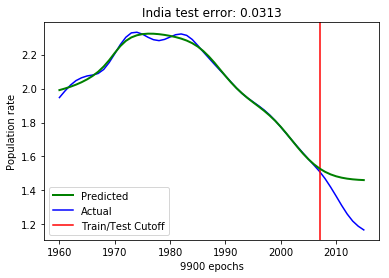

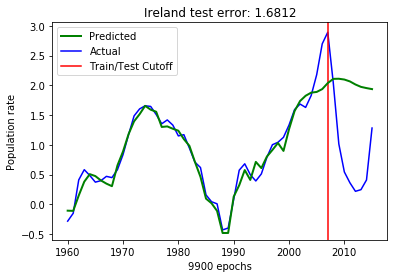

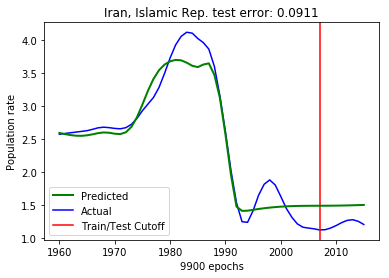

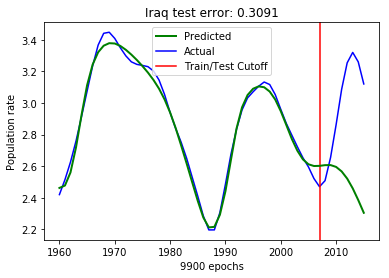

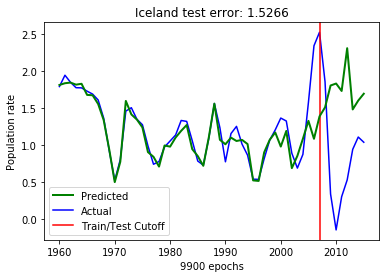

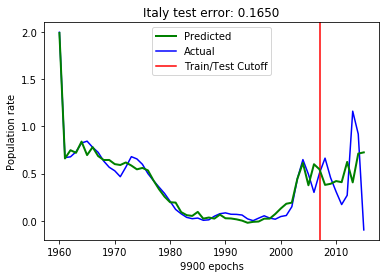

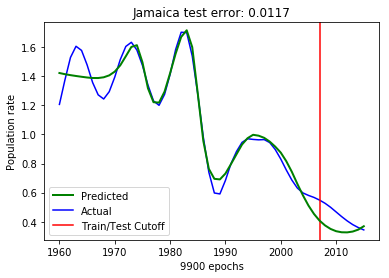

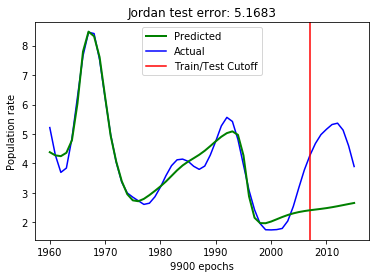

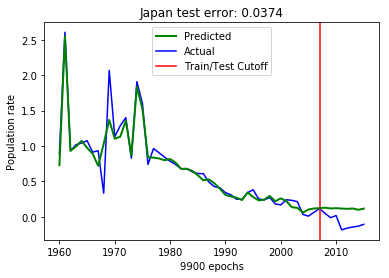

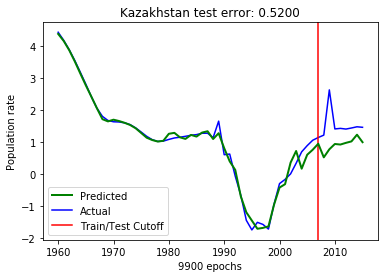

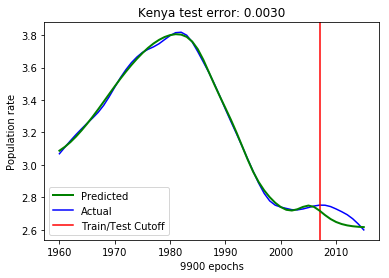

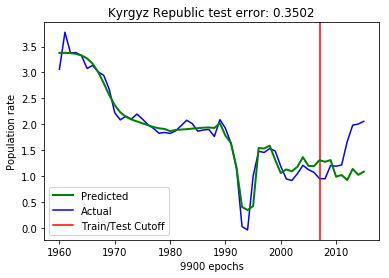

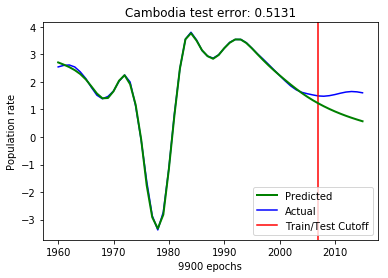

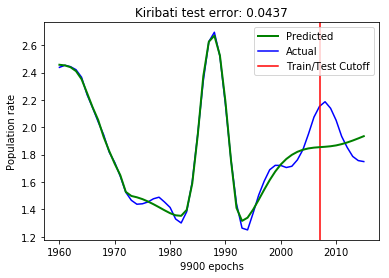

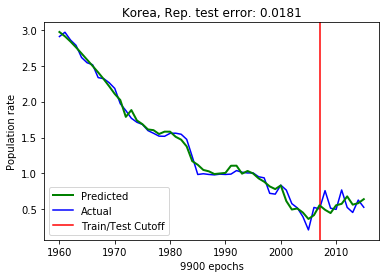

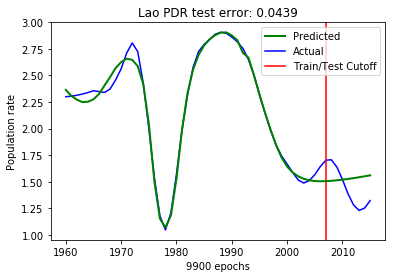

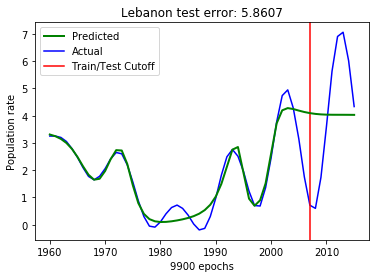

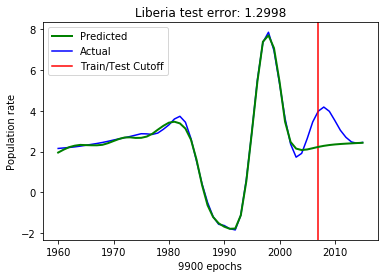

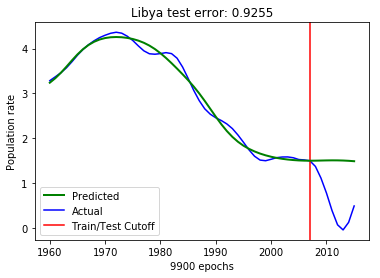

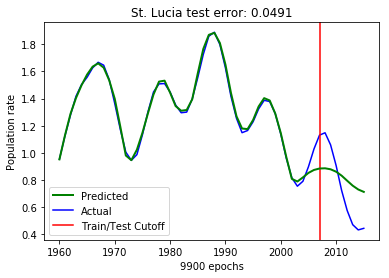

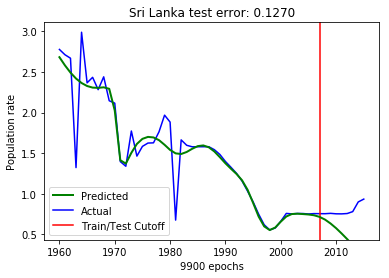

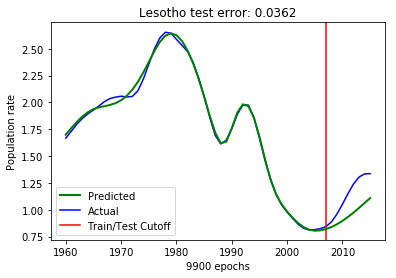

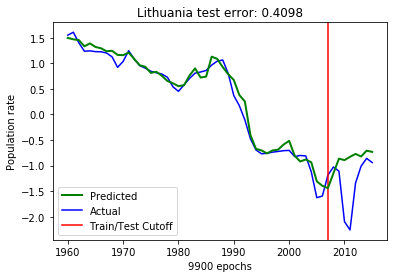

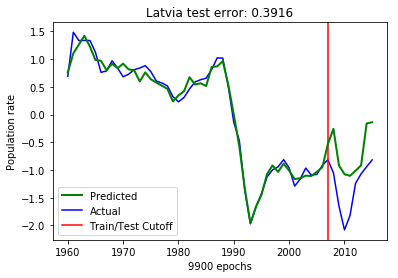

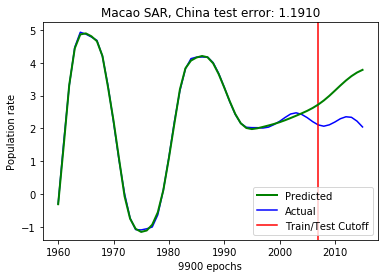

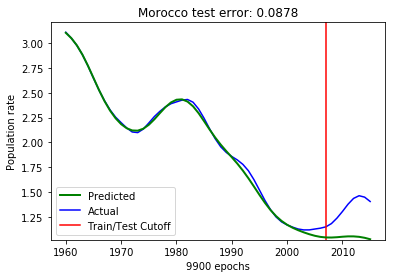

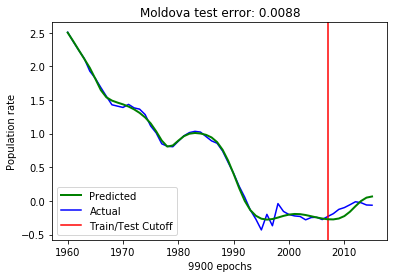

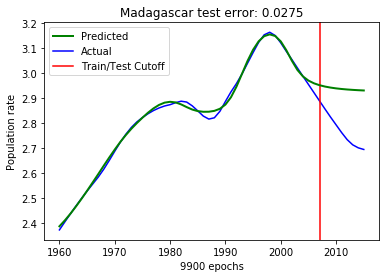

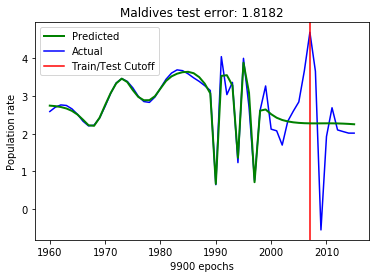

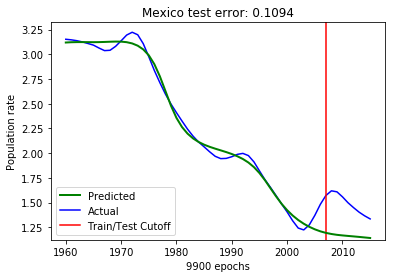

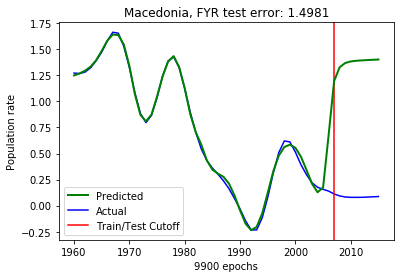

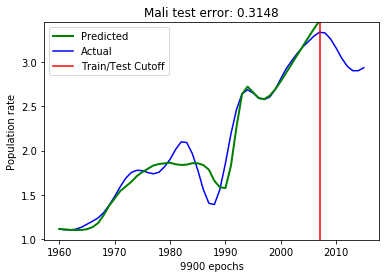

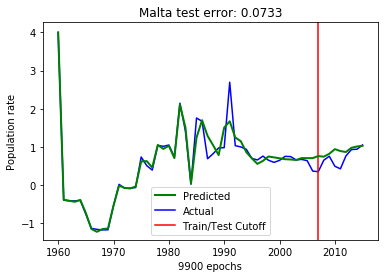

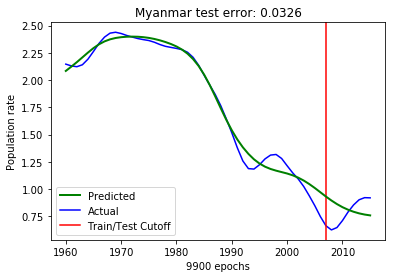

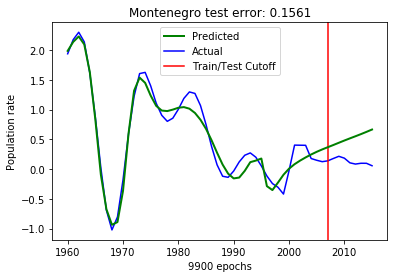

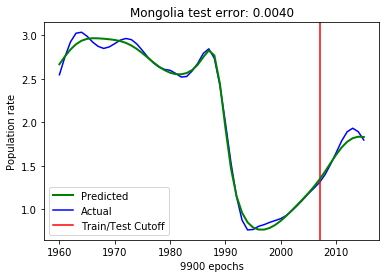

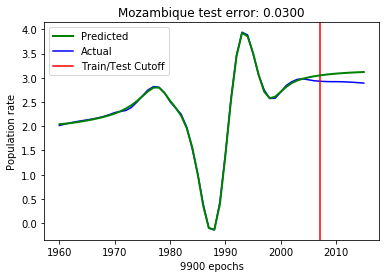

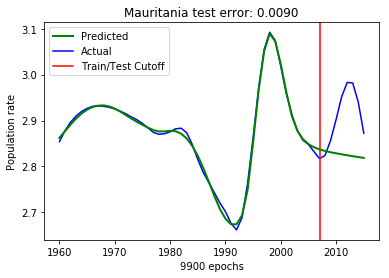

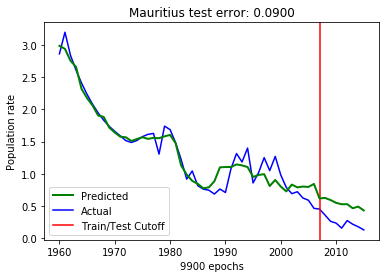

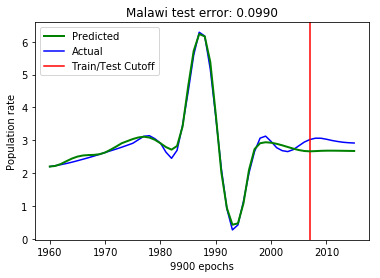

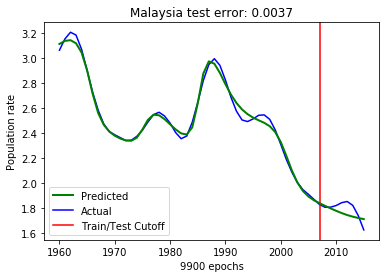

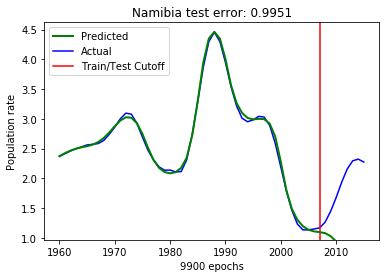

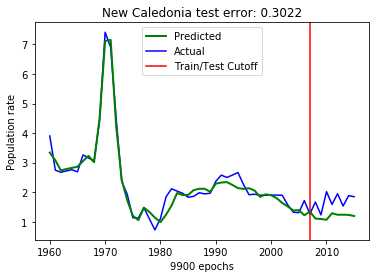

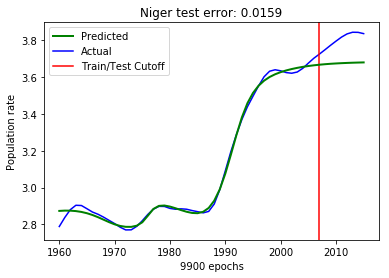

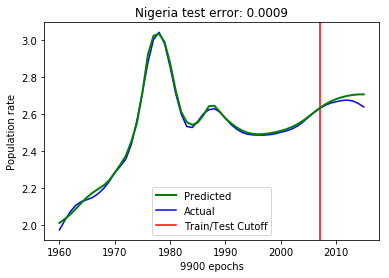

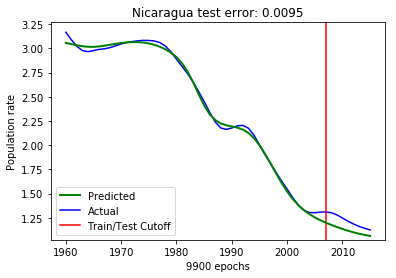

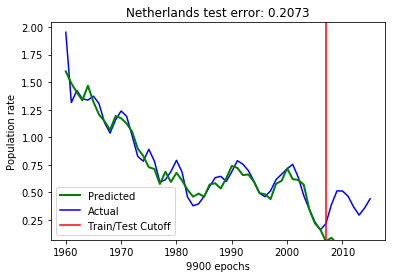

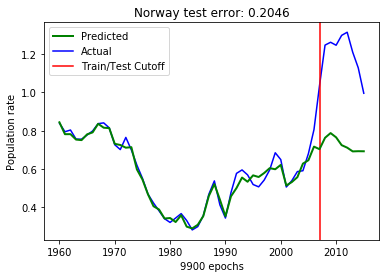

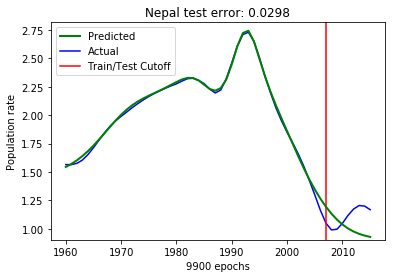

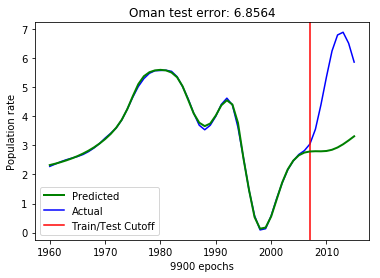

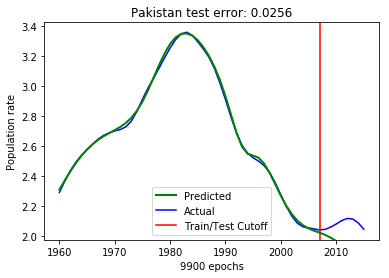

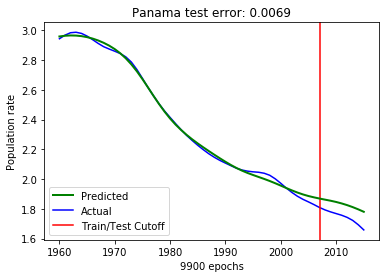

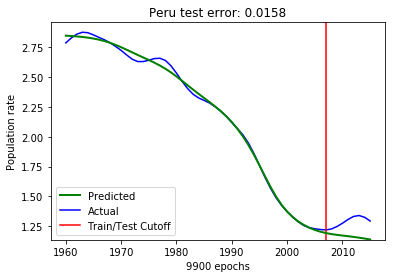

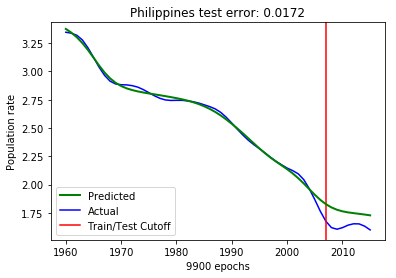

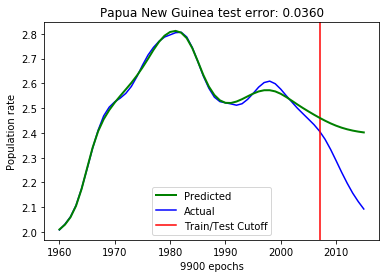

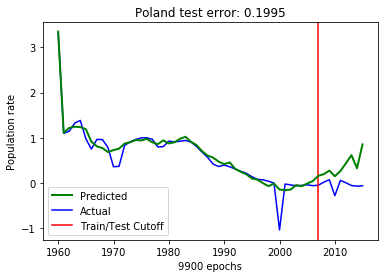

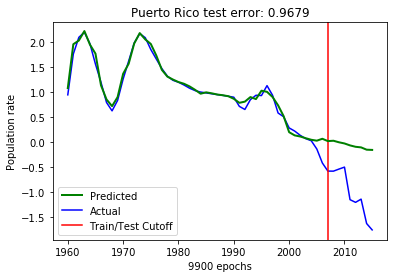

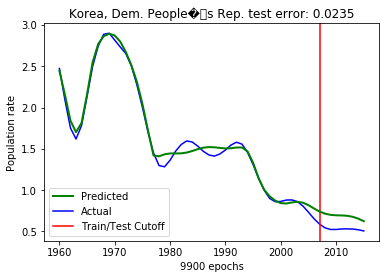

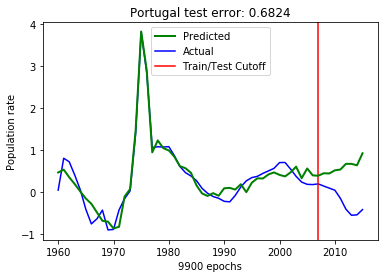

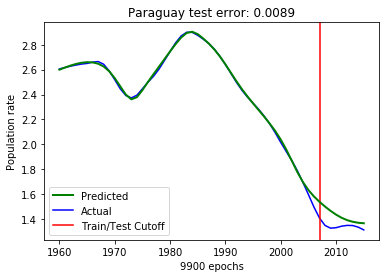

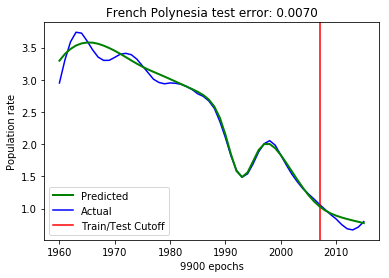

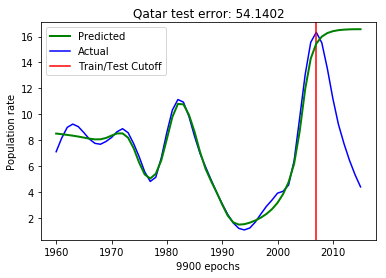

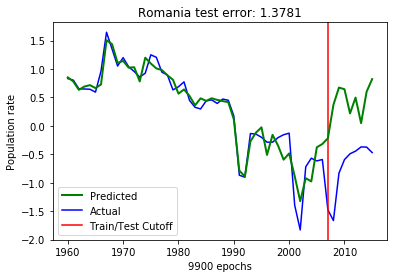

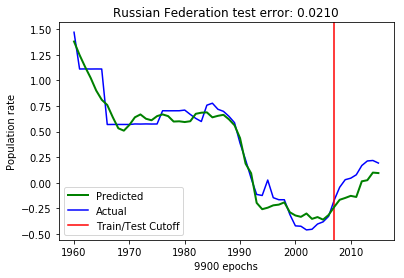

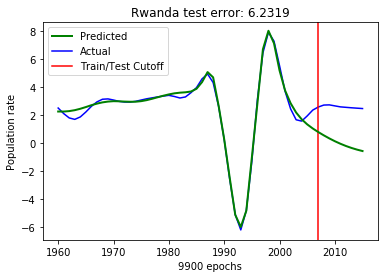

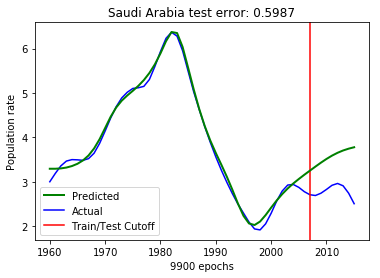

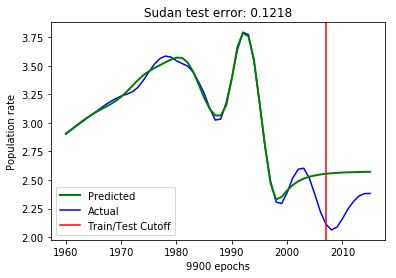

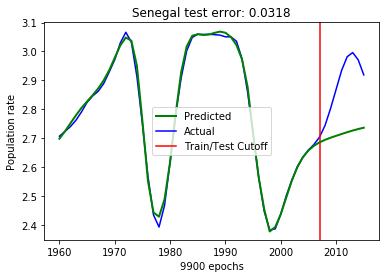

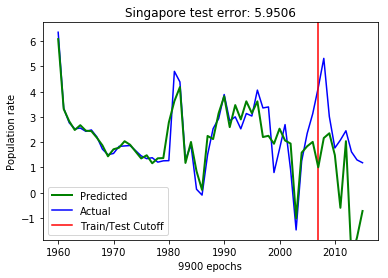

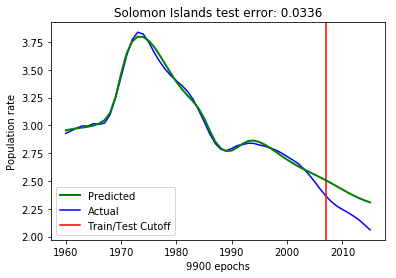

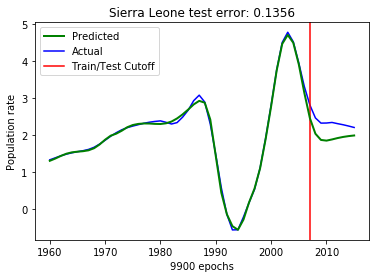

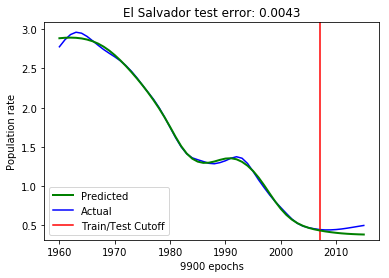

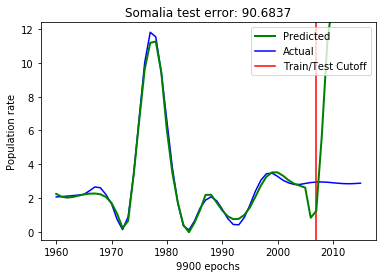

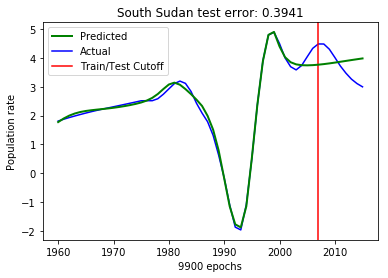

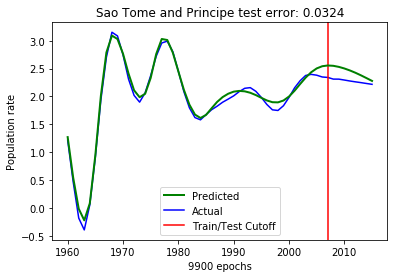

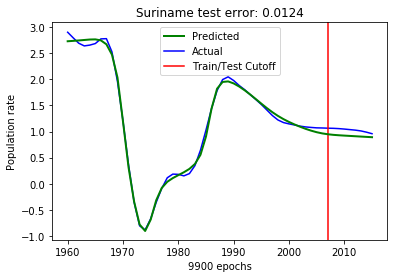

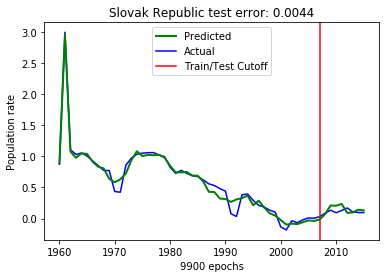

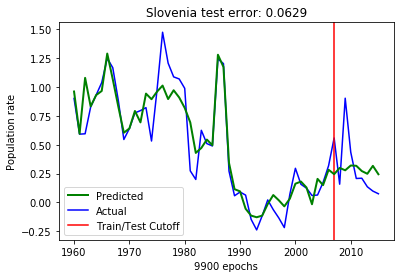

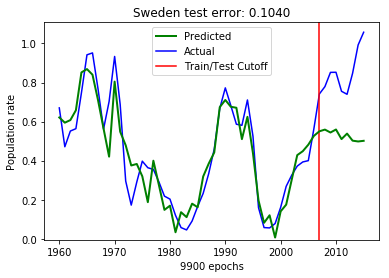

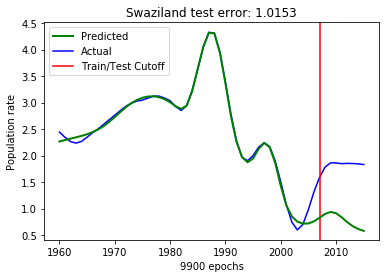

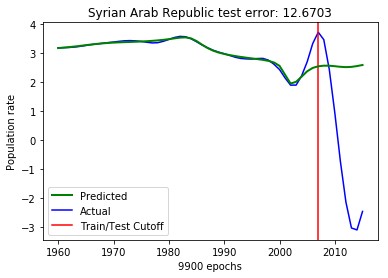

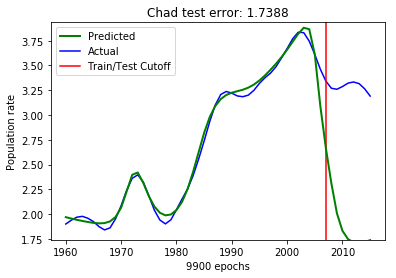

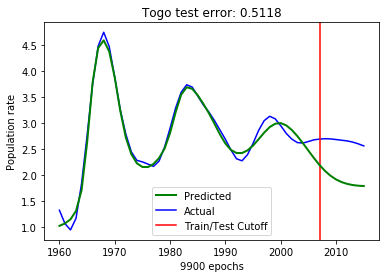

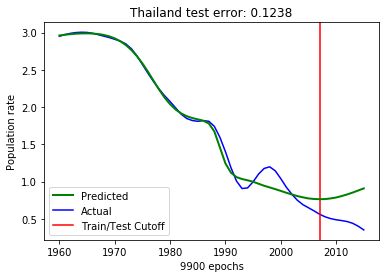

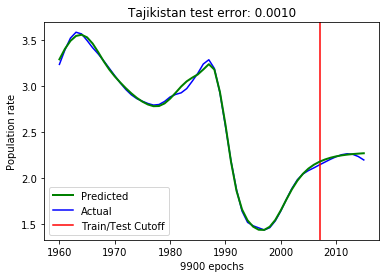

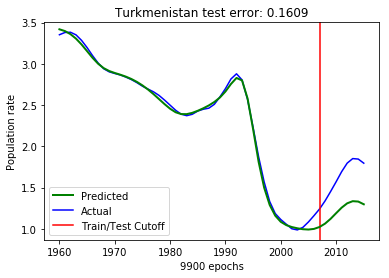

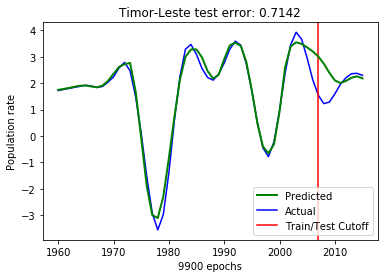

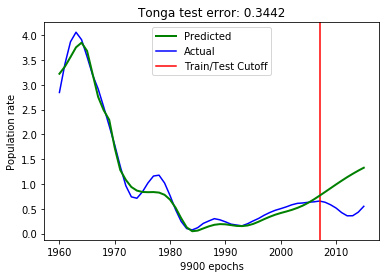

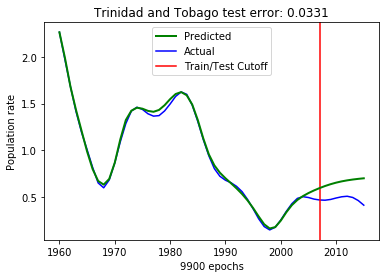

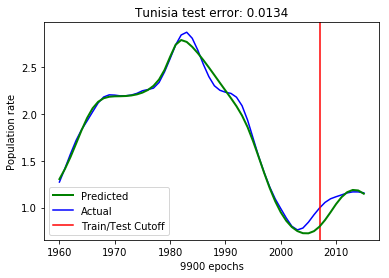

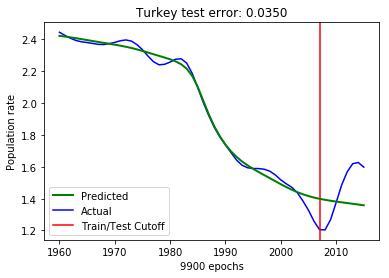

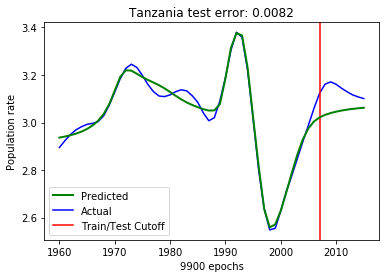

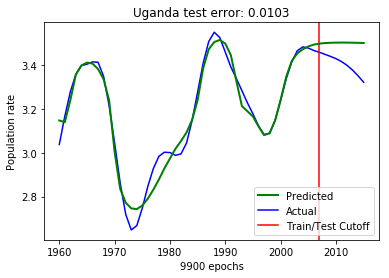

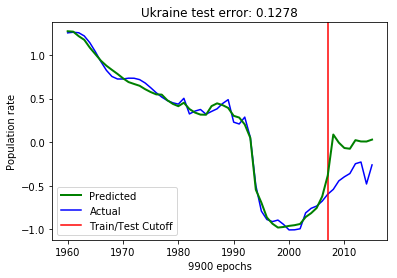

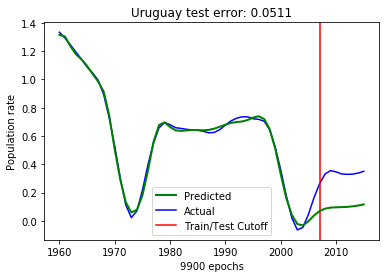

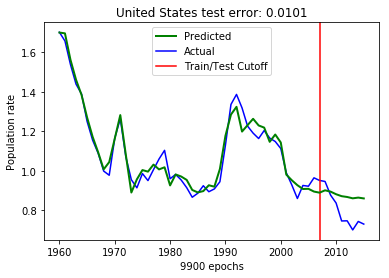

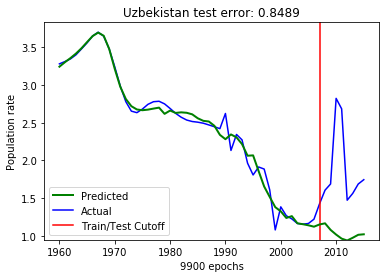

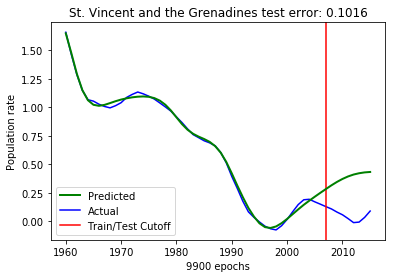

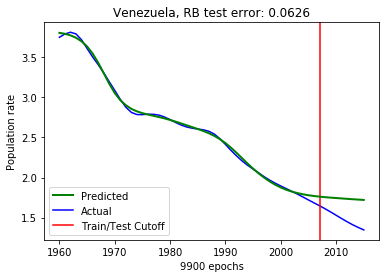

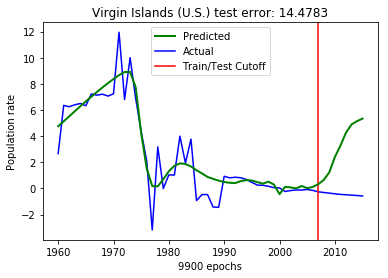

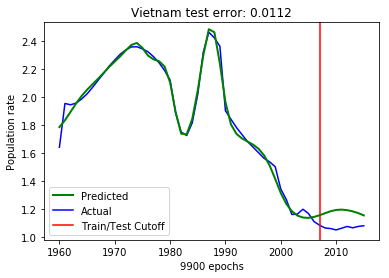

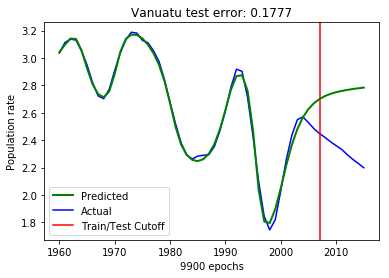

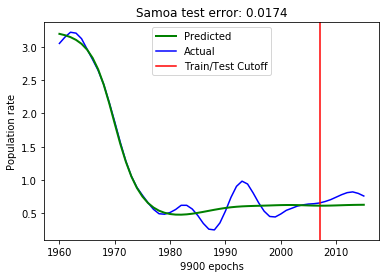

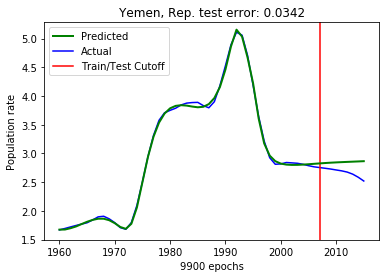

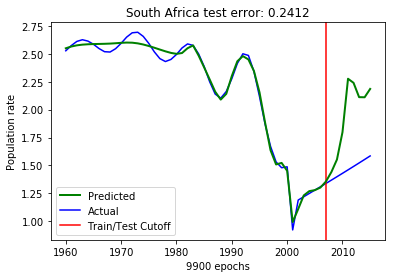

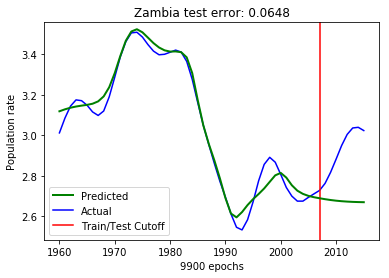

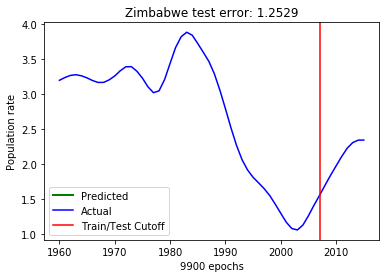

In [173]:
full_countries = [countries[i] for i in range(len(countries)) if len(country_data[i]) == 56]
full_country_data = [country for country in country_data if len(country) == 56]
for country_name in full_countries:
    tf.reset_default_graph()
    tf.set_random_seed(13)
    model = LSTM(display_step=10000, learning_rate=.1)
    filename = "/tmp/model.ckpt"
    country = country_data[countries.index(country_name)]
    num_test_years=10
    num_epochs = 100
    all_x = country[:,:4]
    train_x = country[:-1*num_test_years,:4]
    train_y = col(country[:-1*num_test_years, 4])
    test_x = country[-1*num_test_years:,:4]
    test_y = col(country[-1*num_test_years:,4])
    best_error = 1000
    test_errors = []
    train_errors = []
    years = list(range(1960, 2016))
    fig, ax = plt.subplots()
    actual, = ax.plot(list(range(1960, 2016)), col(country[:,4]), color='blue')
    vert = ax.axvline(2016-num_test_years+1, color='red')
    # ax.set_xlim(( min(years)-2, max(years)+2))
    # ax.set_ylim((-2, 2))
    line, = ax.plot([], [], lw=2, color='green')
    ax.set_ylabel("Population rate")
    def init():
        line.set_data([], [])
        return (line,)
    def update(i):
        label = '{0} epochs'.format(i * num_epochs)
        #print(label)
        # ML stuff
        model.train(train_x, train_y, epochs=num_epochs, print_error=False)
        train_error = model.error(train_x, train_y)
        test_error = model.error(test_x, test_y)
        train_errors.append(train_error)
        test_errors.append(test_error)

        # Update the line and the axes (with a new xlabel). Return a tuple of
        # "artists" that have to be redrawn for this frame.
        line.set_xdata(years)
        line.set_ydata(model.run(all_x))
        ax.set_xlabel(label)

        ax.set_title(country_name + " test error: " + "{0:.4f}".format(test_error[0]))
        ax.legend([line, actual, vert], ["Predicted", "Actual", "Train/Test Cutoff"])
        return line, ax


    anim = FuncAnimation(fig, update, init_func = init, frames=100, interval=100)
    anim.save("gifs/"+country_name + '.gif', dpi=80, writer='imagemagick')
    print(country_name + " finished.")